# Evaluation of image sythesis from PEMIU enhanced templates using ArcFace and ElasticFace



In [1]:
# System
import os

# Data preparation
import pandas as pd
import numpy as np
import math

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pysankey import sankey

import svgutils.compose as sc
from IPython.display import SVG

# Calculations: Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

In [2]:
# -----------------------------------------
# Path settings

# Graphics savepath
plt_savepath = "./final_eval_elasticface_plt/"
os.makedirs(plt_savepath, exist_ok=True)

# Evaluation folder
evaluation_path = "../evaluation/elasticface/"

# Experiment 7 folder (contains evaluation results with ArcFace)
experiment_7_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/"

# Experiment 10 folder (contains ElasticFace)
experiment_10_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/"

# Model training training_files (model trained with ArcFace)
training_files_path = f"{experiment_10_path}training_files_elastic/"

# Plot folder for biometric system eval
plot_bio_sys_eval_path = "./final_eval_ElasticFace_biometric_system_plt/"
# -----------------------------------------

# Global variables
block_sizes = ["16", "32", "64", "128"]
face_extractor = "ElasticFace"

In [3]:
# DataFrame imports

# Pyeer report unprotected for system evaluation
df_pyeer_unprotected = pd.read_csv(f"{evaluation_path}pyeer_lfwview2_pemiu16_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer_unprotected.drop(df_pyeer_unprotected.index[1:], inplace=True)

# Mated / non-mated comparisons (LFW view2), normalized cos_sim calculations
df_genuine = pd.read_csv(f"{evaluation_path}lfwview2_genuine_cos_sim.csv", sep=",")
df_impostor = pd.read_csv(f"{evaluation_path}lfwview2_impostor_cos_sim.csv", sep=",")

# Model 1 training logs
df_model1_training = pd.read_csv(f"{training_files_path}logs_train/generator.csv", sep=",")
df_model1_training_training = pd.read_csv(f"{training_files_path}logs_train/log.txt", sep=",", header=None, names=['epoch', 'iteration','total_loss'])
df_model1_training_training['total_loss'] = df_model1_training_training['total_loss'].apply(lambda x: x.split(':')[-1])

# Visual evaluation
# Dataframe containing filepaths and cos_sim
df_reconstruction_cossim = pd.read_csv(f'../evaluation/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/predicted_labels.csv', index_col=[0])
df_reconstruction_cossim_elasticface = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/predicted_labels.csv', index_col=[0])

# Image quality
#df_image_quality_arcface = pd.read_csv(f"{evaluation_path}image_quality/image_quality_reconstructed_pemiu.csv")

# Cos_sim PEMIU
df_cos_sim_pemiu = pd.read_csv(f"{experiment_10_path}cosine_similarity/cos_sim_samples_pemiu.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected = pd.read_csv(f"{experiment_10_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected_arcface = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')

# Gender prediction ML analysis using k-fold cross validation
df_gender_pred_cv_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_with_cross_validation/attribute_from_img.csv', index_col=[0])
df_gender_pred_cv_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_with_cross_validation/attribute_from_embedding.csv', index_col=[0])

# Gender prediction: Equally distributed dataset
df_gender_pred_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_img.csv', index_col=[0])
df_gender_pred_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_embedding.csv', index_col=[0])
df_gender_pred_from_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/predicted_labels.csv', index_col=[0])

# Gender prediction TH100
df_gender_pred_th100_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_img.csv', index_col=[0])
df_gender_pred_th100_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_embedding.csv', index_col=[0])
df_gender_pred_th100_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/predicted_labels.csv', index_col=[0])

# Gender prediction TH1000
df_gender_pred_th1000_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/attribute_from_img.csv', index_col=[0])
df_gender_pred_th1000_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/predicted_labels.csv', index_col=[0])

# LFW original gender labels
df_pairs_gender = pd.read_csv(f"../evaluation/lfw_complete_genders.csv", sep=",")

# InsightFace prediction
df_insightface_prediction = pd.read_csv(f"{evaluation_path}insightface_gender_prediction/insightface_gender_prediction.csv")

# InsightFace prediction at TH100 and TH1000
df_insightface_prediction_th100 = pd.read_csv(f"{evaluation_path}insightface_gender_prediction_img_that_pass_threshold100/insightface_gender_prediction_that_pass_th100.csv")
df_insightface_prediction_th1000 = pd.read_csv(f"{evaluation_path}insightface_gender_prediction_img_that_pass_threshold1000/insightface_gender_prediction_that_pass_th1000.csv")

In [4]:
# DataFrame modifications
df_cos_sim_all = pd.merge(df_cos_sim_unprotected, df_cos_sim_pemiu, on='filename', how='outer')

In [5]:
df_cos_sim_all

filename  cos_sim_reconstructed_vs_real  \
0           Aaron_Eckhart_0001                       0.534390   
1             Aaron_Guiel_0001                       0.440002   
2         Aaron_Patterson_0001                       0.651367   
3           Aaron_Peirsol_0001                       0.536045   
4           Aaron_Peirsol_0002                       0.580791   
...                        ...                            ...   
13228      Zorica_Radovic_0001                       0.602146   
13229      Zulfiqar_Ahmed_0001                       0.511729   
13230        Zumrati_Juma_0001                       0.596052   
13231     Zurab_Tsereteli_0001                       0.639173   
13232  Zydrunas_Ilgauskas_0001                       0.518040   

       cos_sim_pemiu16_vs_real  cos_sim_pemiu32_vs_real  \
0                    -0.023145                 0.048387   
1                     0.030071                -0.040617   
2                     0.028512                -0.016082   
3                    -0.001336                -0.054832   
4                    -0.037438                 0.126933   
...                        ...                      ...   
13228                -0.056103                 0.147063   
13229                 0.127082                 0.116005   
13230                -0.029655                 0.124419   
13231                -0.074939                -0.019429   
13232                 0.068184                 0.037069   

       cos_sim_pemiu64_vs_real  cos_sim_pemiu128_vs_real  
0                     0.064827                  0.007471  
1                    -0.061398                  0.046234  
2                     0.059366                 -0.069166  
3                    -0.134962                  0.153124  
4                     0.010036                  0.188703  
...                        ...                       ...  
13228                 0.133188                  0.216097  
13229                -0.025746                  0.098096  
13230                 0.145838                 -0.004200  
13231                 0.233633                  0.294958  
13232                -0.100334                 -0.046135  

[13233 rows x 6 columns]

In [6]:
# Helper methods

def one_sample_per_subject(dataframe, evaluation_criteria: str):
    """
    Return a dataframe of LFW image set with only one sample per subject.
    If a subject has more than one sample, it is compared to the other choices by the provided evaluation criterion.

    Args:
        dataframe ():
        evaluation_criteria (): Dataframe column name. Valid choices, e.g.:
                                - img_original_quality

    Returns: pd.DataFrame
    """
    # Dataset should only include one sample per subject
    # Create a dict with name of subject as key and an empty list as value
    subjects = dataframe['filename'].apply(lambda x: x.split('_')[:-1]).tolist()
    subjects = ['_'.join(x) for x in subjects]
    indices = [[] for _ in range(len(subjects))]
    subjects_dict = dict(zip(subjects, indices))
    # Store row indices for each subject as values
    for index, row in dataframe.iterrows():
        if '_'.join(row['filename'].split('_')[:-1]) in subjects_dict:
            subjects_dict['_'.join(row['filename'].split('_')[:-1])].append(index)
    # Iterate over dict, remove all values except one for each key
    for key, value in subjects_dict.items():
        if len(value) > 1:
            # We keep the sample with the greatest value considering the evaluation criteria
            # Get all rows for indices of this subject as series.
            data = dataframe.iloc[subjects_dict[key]]
            # Get the index of the sample with the greatest value considering the criteria
            # Reduce the values to the chosen sample.
            subjects_dict[key] = [data[evaluation_criteria].idxmax()]
    # Iterate over dataframe.
    # Remove all rows which are not in the dictionary containing only unique subjects and samples
    for index, row in dataframe.iterrows():
        if [index] not in subjects_dict.values():
            dataframe.drop(index, inplace=True)

    return dataframe

In [7]:
# Load and modify dataframes
df = pd.read_csv("../evaluation/lfw_complete_genders_with_quality.csv", sep=",")
df = df[['lfw_image', 'img_original_quality', 'lfw_embedding', 'lfw_filename_raw', 'gender_official']]

# Add filename, remove file extension
df['filename'] = df['lfw_filename_raw'].apply(lambda x: x.split('.')[0])
df.drop(columns='lfw_filename_raw', inplace=True)

df.rename(columns={'lfw_embedding': 'embedding_original_arcface'}, inplace=True)
df.rename(columns={'lfw_image': 'img_original'}, inplace=True)

df['embedding_original_elasticface'] = df['filename'].apply(lambda x: f"../data/lfw_align_embeddings_elastic/{x}.npy")

df = df.merge(df_cos_sim_all, left_on="filename", right_on="filename")

# Only include one sample per identity: the one with the highest image quality.
df = one_sample_per_subject(df, "img_original_quality")

# Balance dataset to include a 50/50 amount of male and female samples
num_female = len(df[df["gender_official"] == "F"])
# Get indices of rows with male gender
male_indices = df[df['gender_official'] == "M"].index
# Reduce amount of male indices so that the total matches the number of female samples
male_indices = male_indices[num_female:]
# Drop superfluous indices
df = df.drop(male_indices)

# Samples have missing genders. Drop them.
df = df.drop(df[df['gender_official'] == "X"].index)

# Reset df index
df.reset_index(drop=True, inplace=True)

df_cos_sim_all_reduced = df

df_cos_sim_all_reduced

img_original  img_original_quality  \
0     ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...              0.785188   
1     ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...              0.764814   
2     ../data/lfw_align/Aaron_Patterson/Aaron_Patter...              0.737193   
3     ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...              0.810206   
4      ../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png              0.829048   
...                                                 ...                   ...   
2937  ../data/lfw_align/Zelma_Novelo/Zelma_Novelo_00...              0.834612   
2938   ../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png              0.696282   
2939       ../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png              0.779261   
2940  ../data/lfw_align/Zorica_Radovic/Zorica_Radovi...              0.741519   
2941  ../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...              0.470757   

                             embedding_original_arcface gender_official  \
0       ../data/features_cleaner/Aaron_Eckhart_0001.npy               M   
1         ../data/features_cleaner/Aaron_Guiel_0001.npy               M   
2     ../data/features_cleaner/Aaron_Patterson_0001.npy               M   
3       ../data/features_cleaner/Aaron_Peirsol_0004.npy               M   
4          ../data/features_cleaner/Aaron_Pena_0001.npy               M   
...                                                 ...             ...   
2937     ../data/features_cleaner/Zelma_Novelo_0001.npy               F   
2938       ../data/features_cleaner/Zhang_Ziyi_0003.npy               F   
2939         ../data/features_cleaner/Zoe_Ball_0001.npy               F   
2940   ../data/features_cleaner/Zorica_Radovic_0001.npy               F   
2941     ../data/features_cleaner/Zumrati_Juma_0001.npy               F   

                  filename                     embedding_original_elasticface  \
0       Aaron_Eckhart_0001  ../data/lfw_align_embeddings_elastic/Aaron_Eck...   
1         Aaron_Guiel_0001  ../data/lfw_align_embeddings_elastic/Aaron_Gui...   
2     Aaron_Patterson_0001  ../data/lfw_align_embeddings_elastic/Aaron_Pat...   
3       Aaron_Peirsol_0004  ../data/lfw_align_embeddings_elastic/Aaron_Pei...   
4          Aaron_Pena_0001  ../data/lfw_align_embeddings_elastic/Aaron_Pen...   
...                    ...                                                ...   
2937     Zelma_Novelo_0001  ../data/lfw_align_embeddings_elastic/Zelma_Nov...   
2938       Zhang_Ziyi_0003  ../data/lfw_align_embeddings_elastic/Zhang_Ziy...   
2939         Zoe_Ball_0001  ../data/lfw_align_embeddings_elastic/Zoe_Ball_...   
2940   Zorica_Radovic_0001  ../data/lfw_align_embeddings_elastic/Zorica_Ra...   
2941     Zumrati_Juma_0001  ../data/lfw_align_embeddings_elastic/Zumrati_J...   

      cos_sim_reconstructed_vs_real  cos_sim_pemiu16_vs_real  \
0                          0.534390                -0.023145   
1                          0.440002                 0.030071   
2                          0.651367                 0.028512   
3                          0.641456                -0.016493   
4                          0.723849                 0.004189   
...                             ...                      ...   
2937                       0.711908                 0.297833   
2938                       0.365844                -0.031267   
2939                       0.615362                -0.002230   
2940                       0.602146                -0.056103   
2941                       0.596052                -0.029655   

      cos_sim_pemiu32_vs_real  cos_sim_pemiu64_vs_real  \
0                    0.048387                 0.064827   
1                   -0.040617                -0.061398   
2                   -0.016082                 0.059366   
3                    0.172212                 0.089980   
4                   -0.069601                 0.408504   
...                       ...                      ...   
2937                 

---

## 1. Evaluation of biometric system performance


### Pyeer report

- LFW View 2 protocol

In [6]:
df_pyeer_unprotected.T

0
Experiment ID           Unprotected
GMean                      0.553969
GSTD                       0.153647
IMean                      0.020854
ISTD                       0.074243
Sensitivity index (d')     4.418202
AUC                        0.995609
J-Index                    0.962333
J-Index_TH                 0.195642
MCC                        0.962472
MCC_TH                     0.200038
EERlow                     0.021667
EERhigh                    0.021667
EER                        0.021667
ZeroFMR                    0.066333
FMR1000                    0.063333
FMR100                     0.029333
FMR20                      0.014333
FMR10                      0.009333
ZeroFNMR                   0.922333
EER_TH                     0.180466
ZeroFMR_TH                 0.295983
FMR1000_TH                 0.288248
FMR100_TH                  0.203831
FMR20_TH                   0.146368
FMR10_TH                   0.113246
ZeroFNMR_TH               -0.081928

### Mated and non-mated cosine similarity including system thresholds

- Evaluation of bona fide biometric system performance

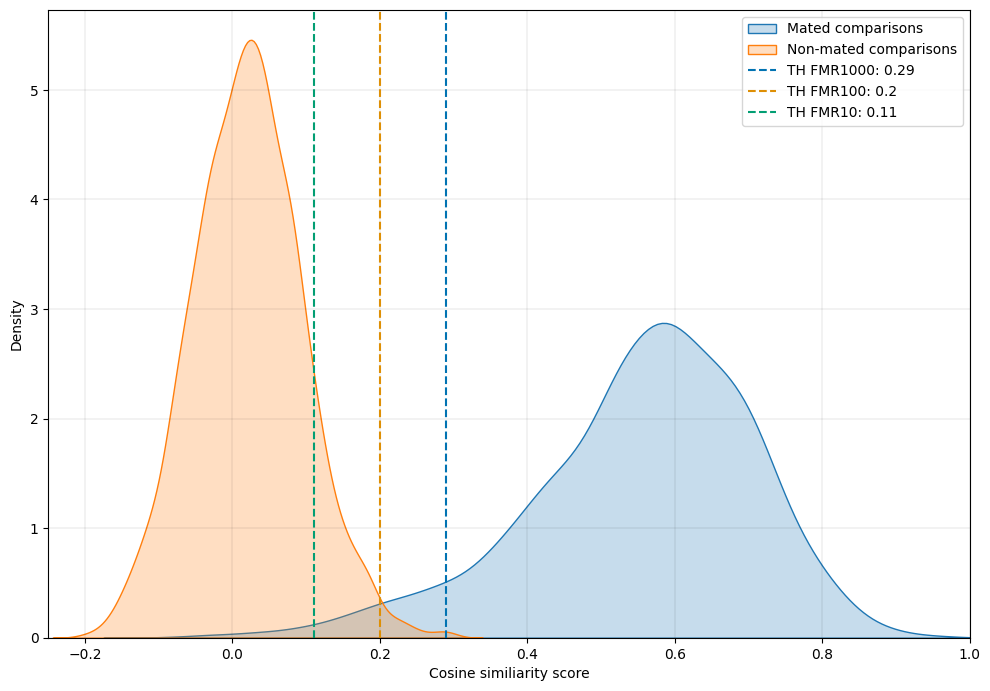

In [7]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Settings
labels_th = ['TH FMR1000', 'TH FMR100', 'TH FMR10']
colors = ["b", "r", "g", "c"]

# Title
# ax.set_title(f"Cosine similarity of LFW View2 comparison pairs and system thresholds using {face_extractor}")
#ax.set_title(f"{face_extractor}")

# Comparison: Genuine and impostor
sns.kdeplot(df_genuine['cos_sim_a_b'], label="Mated comparisons", fill=True)
sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated comparisons", fill=True)

ax.legend()
plt.xlim([-0.25, 1])
plt.xlabel('Cosine similiarity score') # between image comparison pairs

# Thresholds
for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
               color = sns.color_palette("colorblind")[index], linestyle="--",
               label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
ax.legend()

ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}01_01_system_threshold.svg', bbox_inches='tight')
plt.show()

## Evaluation of biometric system with PE-MIU

---

---

## 2. Image reconstruction attack

- Goal: Reconstruct facial images from unprotected embeddings
- Applying the implementation by Shahreza et al.

### Model training

- The model was trained on an FFHQ image set found on Kaggle: https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq The description of the dataset states that the set includes 52,000 files, in fact it consists of 52,001 files. The original FFHQ dataset consists of 70,000 files (https://github.com/NVlabs/ffhq-dataset), but we were unable to download the files from the official source.
- The original samples were of 512x512 px resolution. The samples were cropped and aligned to a certain eye position by applyingmethods from Shahreza et al. implementation in order to have a matching eye position over all of the training files.
- The embeddings used for training the model were generated from the processed samples using ArcFace iResNet100.
- For training, a random selection of 90% of the dataset was used. The remaining 10% were used for testing.
- The training ran for around 17 hours on a nVidia GTX 3090 graphics card to produce 100 model generations.

### Training loss of model 1

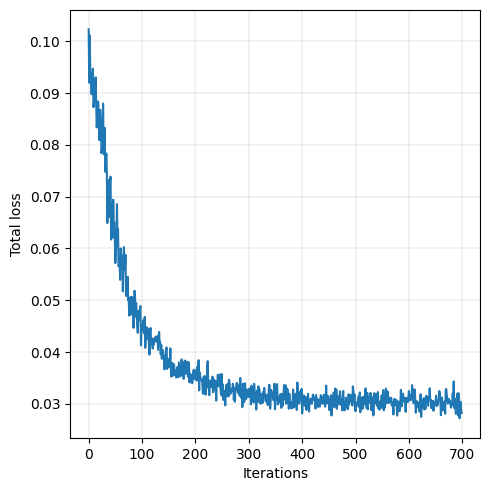

In [8]:
fig, ax = plt.subplots(1, 1,
                        figsize = (5, 5),
                        tight_layout = True)

# ax.set_title(f"Training loss of reconstruction model trained with {face_extractor}")
#ax.set_title(f"{face_extractor}")
ax = sns.lineplot(data=df_model1_training_training['total_loss'].apply(lambda x: float(x)))
ax.set(ylabel="Total loss", xlabel="Iterations")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}02_01_training_loss_model1.svg', bbox_inches='tight')
plt.show()

# df_model1_training_training

### Testing loss of model 1

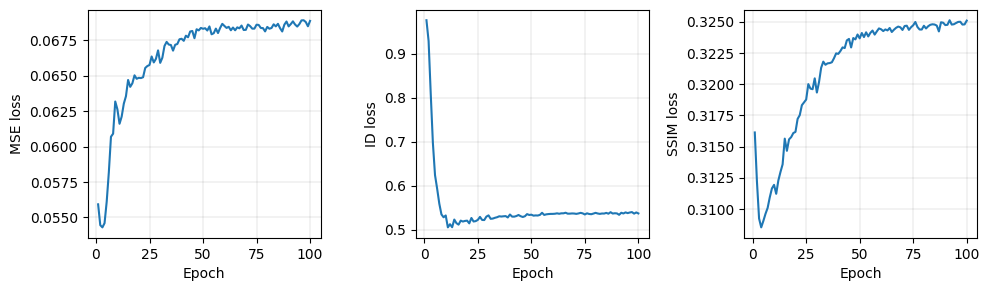

In [9]:
fig, ax = plt.subplots(1, 3,
                        figsize = (10, 3),
                        tight_layout = True)
# fig.suptitle(f"Testing loss of reconstruction model trained with {face_extractor}")
#fig.suptitle(f"{face_extractor}")
ax[0] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['MSE_loss_Gen'], ax=ax[0])
ax[1] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['ID_loss_Gen'], ax=ax[1])
ax[2] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['ssim_loss_Gen_test'], ax=ax[2])
ax[0].set(ylabel="MSE loss")
ax[1].set(ylabel="ID loss")
ax[2].set(ylabel="SSIM loss")
for a in ax:
    a.grid(visible=True, which='major', color='black', linewidth=0.075)
    a.set_xlabel('Epoch')

# Show plot
plt.savefig(f'{plt_savepath}02_02_testing_loss_model1.svg', bbox_inches='tight')
plt.show()

In [ ]:
df_reconstruction_cossim.T


### Visual sample of model training

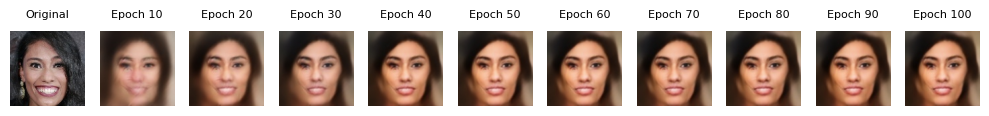

In [11]:
path = f"{training_files_path}Generated_images/14/"
img = []
img.append(mpimg.imread(f"{path}real_image_0.jpg"))
for i in range(10):
    img.append(mpimg.imread(f"{path}epoch_{(i+1)*10}.jpg"))
    
# display images
fig, ax = plt.subplots(1,11,
                       figsize = (10, 7),
                        tight_layout = True)
# fig.suptitle(f"{face_extractor}")
#fig.text(0.5, 0.62, f"{face_extractor}", ha='center', rotation=0)
ax[0].set_title("Original", pad=10, size=8)
for i in range(1, 11):
    ax[i].set_title(f"Epoch {i*10}", pad=10, size=8)

for x in range(len(ax)):
    ax[x].axis('off')
    ax[x].imshow(img[x])
    
plt.savefig(f'{plt_savepath}02_03_model_training_visual_sample.svg', bbox_inches='tight')
plt.show()

In [12]:
def get_original_image(filename):
    return f"../data/lfw_align/{'_'.join(filename.split('_')[:-1])}/{filename}.png"

def get_reconstructed_image(filename, fe:str):
    if fe == "ArcFace":
        path = f"{experiment_7_path}sample_images_unprotected"
        return f"{path}/{filename}_reconstructed.png"
    else:
        path = f"{experiment_10_path}sample_images_unprotected"
        return f"{path}/{filename}_model4_unprotected.png"

def get_pemiu_image(filename, blocksize, fe:str):
    if fe == "ArcFace":
        path = f"{experiment_7_path}sample_images_pemiu{blocksize}"
        return f"{path}/{filename}_pemiu{blocksize}.png"
    else:
        path = f"{experiment_10_path}sample_images_pemiu{blocksize}"
        return f"{path}/{filename}_model4_pemiu{blocksize}.png"

def get_cos_sim(filename, blocksize=False):
    if blocksize:
        return format(round(df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
    #else:
    #    return format(round(df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_unprotected'].tolist()[0], 2), '.2f')

def get_cos_sim_elasticface(filename, blocksize=False):
    if blocksize:
        return format(round(df_reconstruction_cossim_elasticface[df_reconstruction_cossim_elasticface['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
    #else:
    #    return format(round(df_reconstruction_cossim_elasticface[df_reconstruction_cossim_elasticface['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_unprotected'].tolist()[0], 2), '.2f')

def get_gender_prediction(filename, blocksize):
    return df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]

def get_gender(filename):
    return df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'gender_official'].tolist()[0]
    
def display_image(filename, display_title=False):
    fig, ax = plt.subplots(1,3,
                           figsize = (6, 7),
                           tight_layout = True)
    if display_title:
        ax[0].set_title(f"Original", pad=10)
        ax[1].set_title("ArcFace", pad=10)
        ax[2].set_title("ElasticFace", pad=10)
    
    # Display cosine similarity score
    ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(80, 105, get_cos_sim(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(80, 105, get_cos_sim_elasticface(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_original_image(filename)))
    ax[1].imshow(mpimg.imread(get_reconstructed_image(filename, "ArcFace")))
    ax[2].imshow(mpimg.imread(get_reconstructed_image(filename, "ElasticFace")))
     
    for x in range(0, 3):
        ax[x].axis('off')

In [13]:
# Sort dataframe for greatest cos_sim of recontructed image
df_reconstruction_cossim.sort_values(by='cos_sim_bonafide_synthesized_unprotected_normalized', axis=0, ascending=False, inplace=True)

### Reconstruct images from unprotected embeddings

- Use the model to reconstruct images from LFW dataset
- Embeddings created using ArcFace IResNet 100
- Random sample of images with high cosine similarity
- Number displayed in reconstructed image is cosine similarity

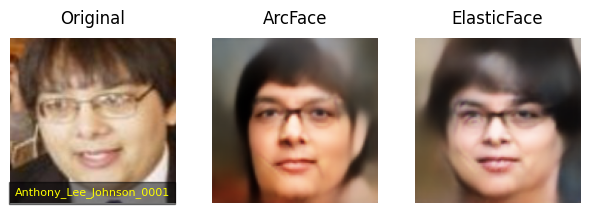

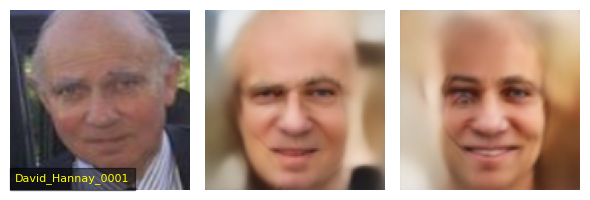

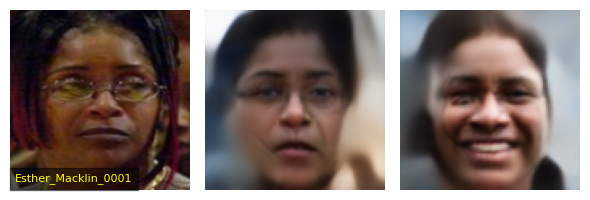

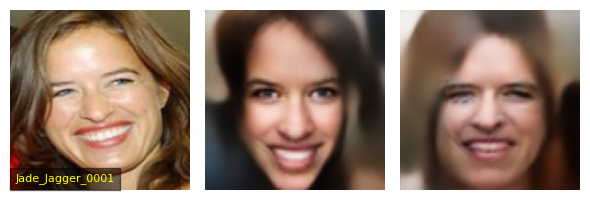

In [14]:
# Highest cos_sim for male subjects
for i, index in enumerate([11, 189, 246, 601]):
    if i == 0:
        display_image(df_reconstruction_cossim['filename'].iloc[index], display_title=True)
    else:
        display_image(df_reconstruction_cossim['filename'].iloc[index])
    plt.savefig(f'{plt_savepath}02_04_{i}_reconstruct_images.svg', bbox_inches='tight')

### Evaluation of attack performance

- LFW View 2 comparison paris
- SISFE (Same image same feature extractor), also called Type-I attack
    - Cosine similarity between original image and reconstructed image
    - Origin of the reconstructed image is the embedding of the original image
- DIFSE (Differnet image same feature extractor), also called Type-II attack
    - Cosine similarity between original image and recontructed image from the original image's embedding
    - Origin of the reconstructed image is an embedding from a different sample of the same subject

In [15]:
df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]

FMR1000_TH  FMR100_TH  FMR10_TH
0    0.288248   0.203831  0.113246

In [16]:
df_genuine

Unnamed: 0                                              a_img  \
0              0  ../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...   
1              1  ../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...   
2              2  ../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...   
3              3  ../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...   
4              4  ../data/lfw_align/Anders_Fogh_Rasmussen/Anders...   
...          ...                                                ...   
2995        2995  ../data/lfw_align/Vladimir_Voltchkov/Vladimir_...   
2996        2996         ../data/lfw_align/Wang_Yi/Wang_Yi_0001.png   
2997        2997  ../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...   
2998        2998   ../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png   
2999        2999   ../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0002.png   

                                                  b_img  \
0     ../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...   
1     ../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...   
2     ../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...   
3     ../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...   
4     ../data/lfw_align/Anders_Fogh_Rasmussen/Anders...   
...                                                 ...   
2995  ../data/lfw_align/Vladimir_Voltchkov/Vladimir_...   
2996         ../data/lfw_align/Wang_Yi/Wang_Yi_0002.png   
2997  ../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...   
2998   ../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png   
2999   ../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0008.png   

                                            a_embedding  \
0     ../data/lfw_align_embeddings_elastic/Abel_Pach...   
1     ../data/lfw_align_embeddings_elastic/Akhmed_Za...   
2     ../data/lfw_align_embeddings_elastic/Akhmed_Za...   
3     ../data/lfw_align_embeddings_elastic/Amber_Tam...   
4     ../data/lfw_align_embeddings_elastic/Anders_Fo...   
...                                                 ...   
2995  ../data/lfw_align_embeddings_elastic/Vladimir_...   
2996  ../data/lfw_align_embeddings_elastic/Wang_Yi_0...   
2997  ../data/lfw_align_embeddings_elastic/Zafarulla...   
2998  ../data/lfw_align_embeddings_elastic/Zhu_Rongj...   
2999  ../data/lfw_align_embeddings_elastic/Zhu_Rongj...   

                                            b_embedding  \
0     ../data/lfw_align_embeddings_elastic/Abel_Pach...   
1     ../data/lfw_align_embeddings_elastic/Akhmed_Za...   
2     ../data/lfw_align_embeddings_elastic/Akhmed_Za...   
3     ../data/lfw_align_embeddings_elastic/Amber_Tam...   
4     ../data/lfw_align_embeddings_elastic/Anders_Fo...   
...                                                 ...   
2995  ../data/lfw_align_embeddings_elastic/Vladimir_...   
2996  ../data/lfw_align_embeddings_elastic/Wang_Yi_0...   
2997  ../data/lfw_align_embeddings_elastic/Zafarulla...   
2998  ../data/lfw_align_embeddings_elastic/Zhu_Rongj...   
2999  ../data/lfw_align_embeddings_elastic/Zhu_Rongj...   

                                    a_img_reconstructed  \
0     ./experiments/experiment_10_elastic/sample_ima...   
1     ./experiments/experiment_10_elastic/sample_ima...   
2     ./experiments/experiment_10_elastic/sample_ima...   
3     ./experiments/experiment_10_elastic/sample_ima...   
4     ./experiments/experiment_10_elastic/sample_ima...   
...                                                 ...   
2995  ./experiments/experiment_10_elastic/sample_ima...   
2996  ./experiments/experiment_10_elastic/sample_ima...   
2997  ./experiments/experiment_10_elastic/sample_ima...   
2998  ./experiments/experiment_10_elastic/sample_ima...   
2999  ./experiments/experiment_10_elastic/sample_ima...   

                                    b_img_reconstructed  \
0     ./experiments/experiment_10_elastic/sample_ima...   
1     ./experiments/experiment_10_elastic/sample_ima...   
2     ./experiments/experiment_10_elastic/sample_ima...   
3     ./experiments/experiment_10_elastic/sample_ima...   
4     ./experiments/ex

In [17]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_genuine[df_genuine['cos_sim_a_a_reconstructed'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_genuine) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[99.7, 99.93, 100.0]

In [18]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_genuine[df_genuine['cos_sim_a_b_reconstructed'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_genuine) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[59.93, 82.23, 94.6]

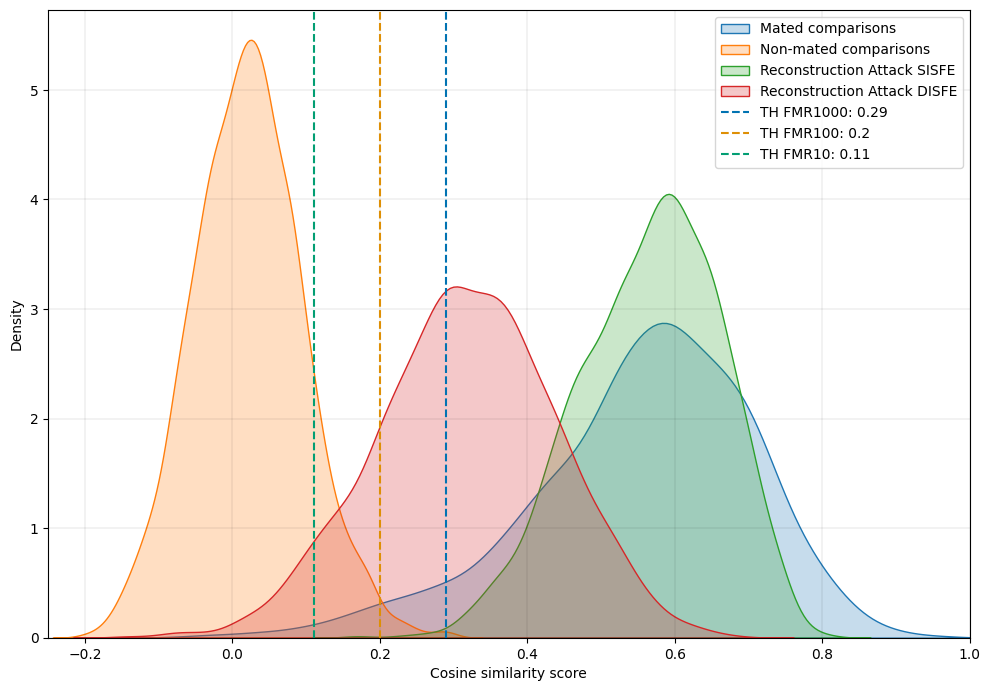

In [19]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"Cosine similarity of LFW View2 comparison pairs using {face_extractor}:\n" \
#              "Mated/non-mated, reconstructed images (unprotected templates), system thresholds")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['TH FMR1000', 'TH FMR100', 'TH FMR10']
colors = ["b", "r", "g", "c"]

sns.kdeplot(df_genuine['cos_sim_a_b'], ax=ax, label="Mated comparisons", fill=True)
sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated comparisons", fill=True)
sns.kdeplot(df_genuine['cos_sim_a_a_reconstructed'], label="Reconstruction Attack SISFE", fill=True)
sns.kdeplot(df_genuine['cos_sim_a_b_reconstructed'], label="Reconstruction Attack DISFE", fill=True)

ax.legend()
plt.xlim([-0.25, 1])
ax.set(xlabel="Cosine similarity score")  # between image compaison pairs

# Thresholds
for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
               color = sns.color_palette("colorblind")[index], linestyle="--", 
               label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
ax.legend()
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

# Show plot
plt.savefig(f'{plt_savepath}02_05_attack_performance.svg', bbox_inches='tight')
plt.show()

## Attack success rate for unprotected

In [20]:
df_pyeer_unprotected[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]

ZeroFMR_TH  FMR1000_TH  FMR100_TH  FMR10_TH
0    0.295983    0.288248   0.203831  0.113246

In [21]:
df_cos_sim_all['cos_sim_reconstructed_vs_real']

0        0.534390
1        0.440002
2        0.651367
3        0.536045
4        0.580791
           ...   
13228    0.602146
13229    0.511729
13230    0.596052
13231    0.639173
13232    0.518040
Name: cos_sim_reconstructed_vs_real, Length: 13233, dtype: float64

In [22]:
df_pyeer_unprotected['FMR1000_TH'].values[0]

0.288248062133789

In [23]:
len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_reconstructed_vs_real'] > round(df_pyeer_unprotected['FMR1000_TH'].values[0], 2)])

13148

In [24]:
#df_cos_sim_all[df_cos_sim_all[f'cos_sim_reconstructed_vs_real_normalized'] > round(df_pyeer_unprotected[row].values[0], 2)]

labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
successful_attacks = []

for i, row in enumerate(labels_th):
    num = len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_reconstructed_vs_real'] > round(df_pyeer_unprotected[row].values[0], 2)])
    num = round((num / len(df_cos_sim_all) * 100), 2)
    print(f"{row}: {num}%")

    #successful_attacks.append(num)
    
#successful_attacks

ZeroFMR_TH: 99.25%
FMR1000_TH: 99.36%
FMR100_TH: 99.74%
FMR10_TH: 99.87%


### Image quality of original and reconstructed images
- SER-FIQ quality assessment

NameError: name 'df_image_quality_arcface' is not defined

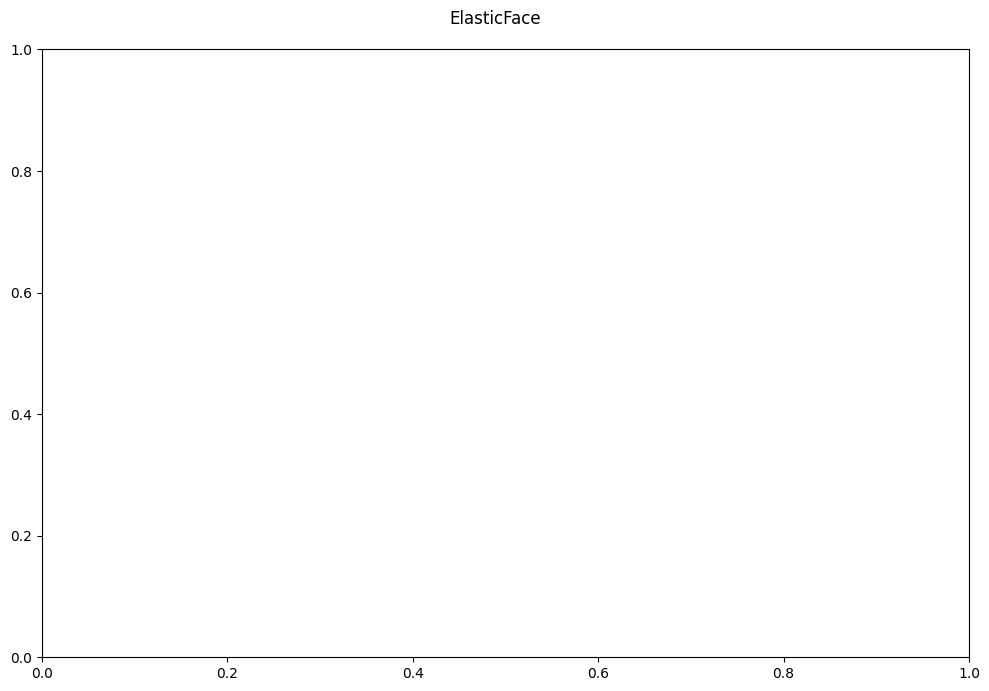

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7), tight_layout = True)
# Title
# fig.suptitle(f"Evaluation of image quality between original and reconstructed images using {face_extractor}")
fig.suptitle(f"{face_extractor}")
# Settings
labels = ["Original", "Reconstructed Unprotected"]

sns.kdeplot(df_image_quality_arcface[f'quality_img_original'], ax=ax, label=labels[0], fill=True)
sns.kdeplot(df_image_quality_arcface[f'quality_img_reconstructed'], ax=ax, label=labels[1], fill=True)
ax.label_outer()
ax.legend(loc=2)
ax.set(xlabel="SER-FIQ image quality score")    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
    
# Render plot
plt.xlim([0, 1])
plt.savefig(f'{plt_savepath}02_06_image_quality.svg', bbox_inches='tight')
plt.show()

---

## 3. Privacy-enhancement using PEMIU

- Enhance privacy of embeddings using PEMIU by Terhörst et al.
- Create PEMIU embeddings with varying block sizes: 16, 32, 64, 128

### Cosine similarity between images reconstructed from PEMIU enhanced templates and original images

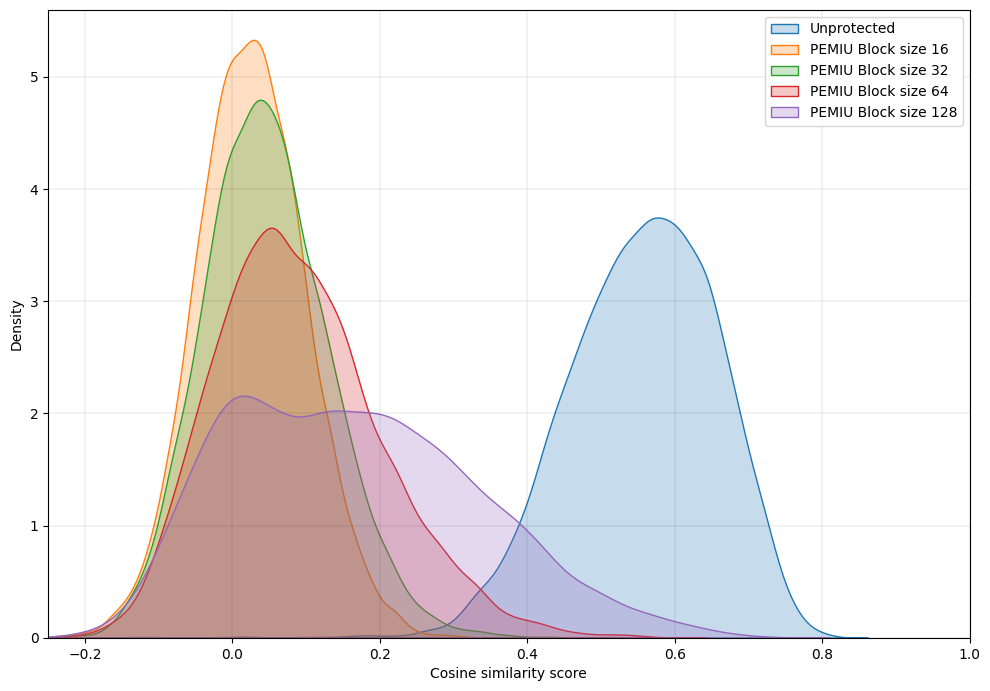

In [26]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# todo: Add comment
sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
for blocksize in block_sizes:
    sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'], label=f"PEMIU Block size {blocksize}", fill=True)

ax.legend()
# ax.set_title(f"Cosine similarity between original images and reconstructed images:\n" \
#              f"Unprotected, PEMIU enhanced at varying block sizes using {face_extractor}")
#ax.set_title(f"{face_extractor}")
plt.xlim([-0.25, 1])
ax.set(xlabel="Cosine similarity score")  # between comparison pairs
    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}03_01_cossim_original_reconstructed_pemiu.svg', bbox_inches='tight')
plt.show()

### SISFE attack performed with PEMIU enhanced images

- Compare cosine similarity between images reconstrcuted from unprotected embeddings with images reconstructed from PEMIU enhanced embeddings at varying block sizes
- Display biometric system acceptance thresholds
- Block size is the PEMIU shuffle block size parameter

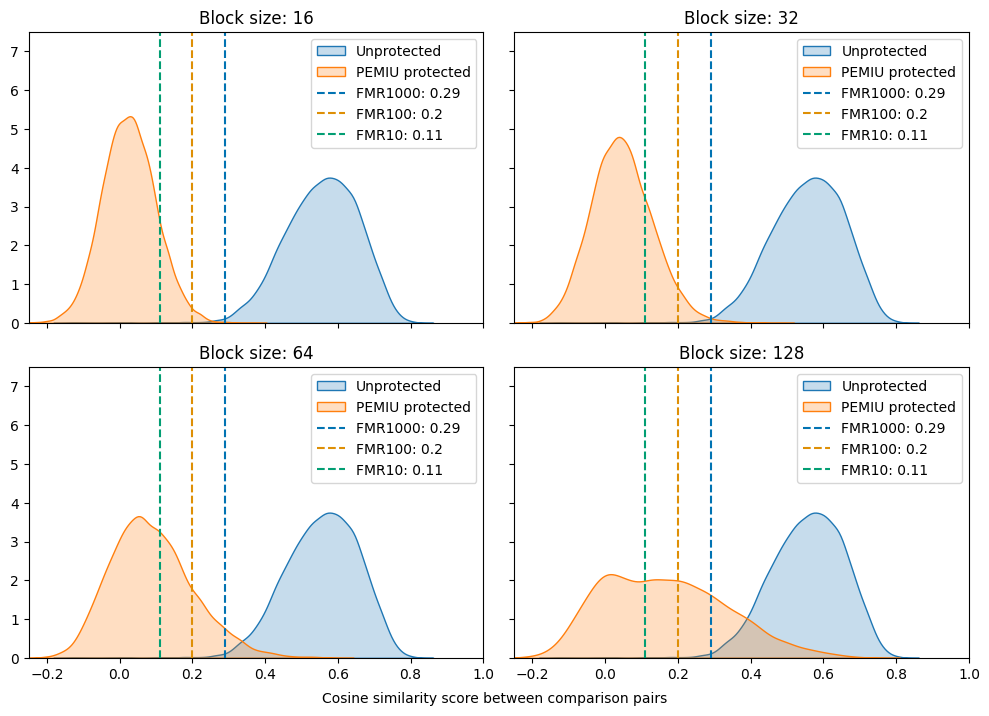

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"SISFE Attack: Reconstructed images from unprotected embeddings,\n" \
#              f"PEMIU enhanced embeddings at varying block sizes, system thresholds, using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['FMR1000', 'FMR100', 'FMR10']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
    sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'], ax=ax, label=f"PEMIU protected", fill=True)
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(-0.25, 1)
    ax.set_ylim(0, 7.5)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
        ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
                   color = sns.color_palette("colorblind")[index], 
                   linestyle="--",
                   label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
    ax.legend()
    ax.set(xlabel="")
    ax.set(ylabel="")
    # .grid(visible=True, which='major', color='black', linewidth=0.075)

# plt.xlabel = "Normalized cosine similarity score between comparison pairs"
fig.text(0.5, -0.01, 'Cosine similarity score between comparison pairs', ha='center')
    
# Render plot
plt.xlim([-0.25, 1])
plt.savefig(f'{plt_savepath}03_02_sisfe_attack_pemiu_at_system_threshold.svg', bbox_inches='tight')
plt.show()

### Success attack rate using images reconstructed from PEMIU enhanced embeddings

In [8]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    for blocksize in block_sizes:
        num = len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all) * 100), 2)
        successful_attacks.append(num)
successful_attacks

[0.08, 0.59, 5.32, 23.94, 1.04, 3.8, 15.42, 39.48, 11.72, 20.83, 38.19, 57.95]

In [9]:
# Attack success rates with reduced and balacned dataset: vs. PEMIU protected templates

successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    for blocksize in block_sizes:
        num = len(df_cos_sim_all_reduced[df_cos_sim_all_reduced[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all_reduced) * 100), 2)
        successful_attacks.append(num)
successful_attacks

[0.03, 0.71, 6.25, 26.1, 1.33, 4.72, 17.57, 41.71, 12.41, 22.4, 40.45, 58.87]

In [10]:
# Attack success rates with reduced and balacned dataset: vs. Unmodified templates

successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_cos_sim_all_reduced[df_cos_sim_all_reduced[f'cos_sim_reconstructed_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_cos_sim_all_reduced) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[99.56, 99.66, 99.9]

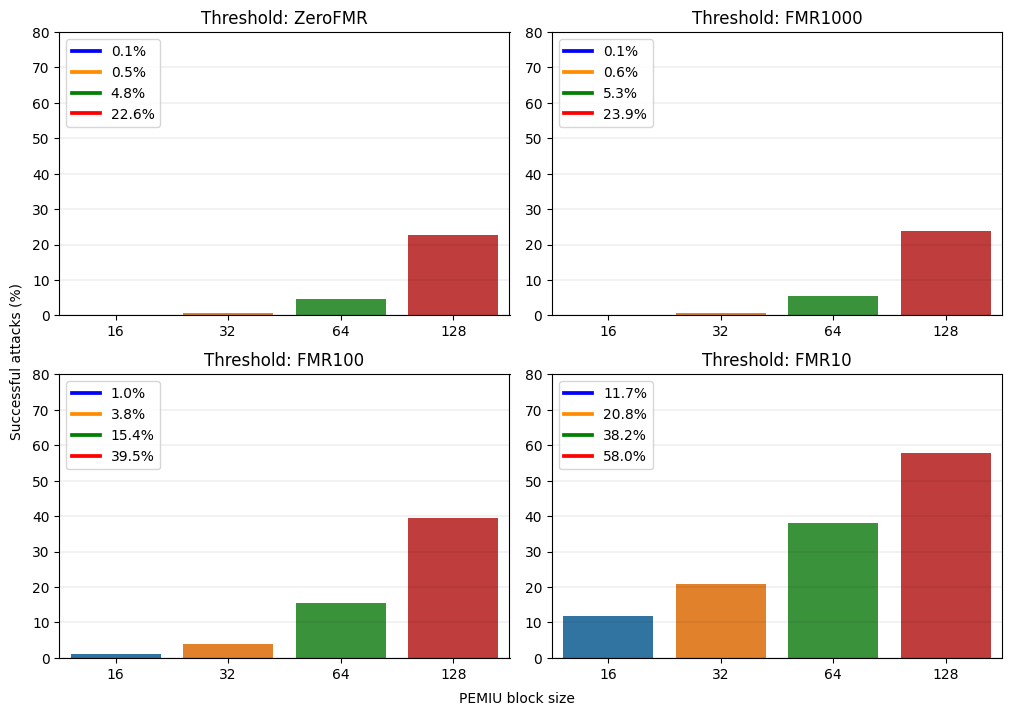

In [55]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 7), tight_layout = True)

# Title
# fig.suptitle("Sucess attack rates of images reconstructed from PEMIU enhanced embeddings\n" \
#              f"at varying block sizes using {face_extractor} and grouped by different system thresholds")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['ZeroFMR', 'FMR1000', 'FMR100', 'FMR10']

# 
for i, (row, ax) in enumerate(zip(df_pyeer_unprotected[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']], fig.get_axes())):
    successful_attacks = []
    for blocksize in block_sizes:
        num = len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all) * 100), 2)
        successful_attacks.append(num)
    ax.set_title(f"Threshold: {labels_th[i]}")
    ax.set_ylim(0, 80)
    ax.grid(visible=True, which='major', color='black', linewidth=0.075)
    #ax.set_ylabel("Successful attacks (%)")
    # ax.set_xlabel("PEMIU block size")
    sns.barplot(x=block_sizes, y=successful_attacks, ax=ax)
    ax.legend(labels=[f"{format(round(x, 1), '.1f')}%" for x in successful_attacks], loc=2)
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('darkorange')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('red')

fig.text(0.5, -0.01, 'PEMIU block size', ha='center')
fig.text(0, 0.37, 'Successful attacks (%)', ha='center', rotation=90)
# Render plot
plt.savefig(f'{plt_savepath}03_03_sisfe_attack_success_rates_at_thresholds.svg', bbox_inches='tight')
plt.show()

### Image quality of images reconstructed from PEMIU enhanced embeddings
- SER-FIQ quality assessment

NameError: name 'df_image_quality_arcface' is not defined

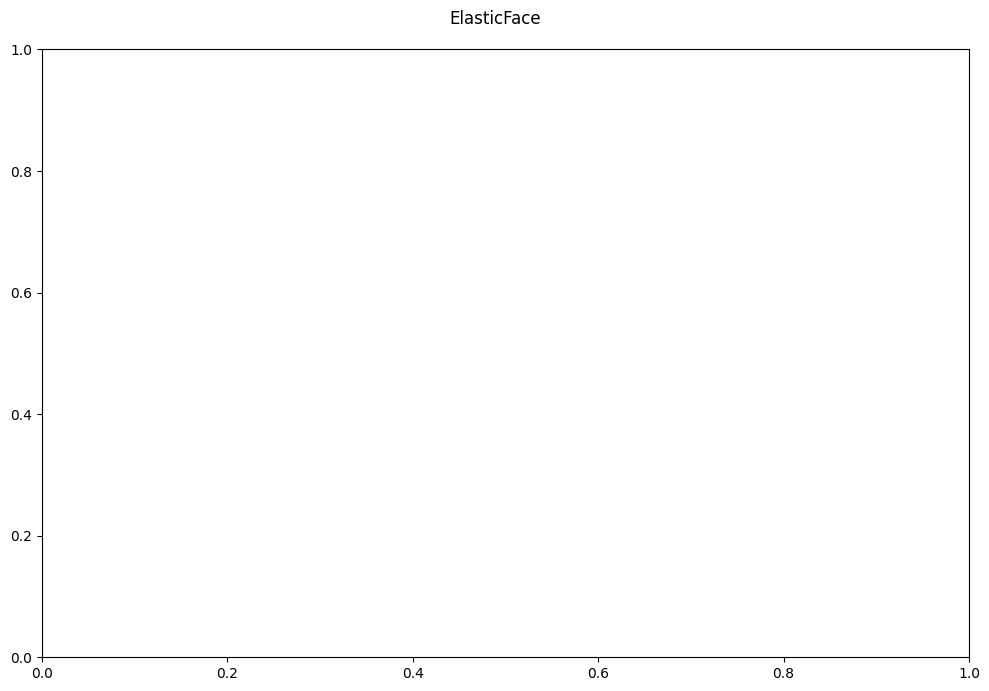

In [20]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"Image quality comparison using {face_extractor}")
fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]
labels = ["Original", "Reconstructed Unprotected"]

sns.kdeplot(df_image_quality_arcface[f'quality_img_original'], ax=ax, label=f"Original", fill=True)
sns.kdeplot(df_image_quality_arcface[f'quality_img_reconstructed'], ax=ax, label=f"Reconstructed Unprotected", fill=True)
for blocksize in block_sizes:
    sns.kdeplot(df_image_quality_arcface[f'quality_img_pemiu_{blocksize}'], ax=ax, label=f"Reconstructed PEMIU {blocksize}", fill=True)
# ax.set_title(f"Reconstructed")

for i, (ax) in enumerate( fig.get_axes() ):
    # sns.kdeplot(df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'], ax=ax, label=f"PEMIU protected", fill=True)
    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 7.5)
    ax.label_outer()
    ax.legend(loc=2)
    ax.set(xlabel="SER-FIQ image quality score")
    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Render plot
plt.xlim([0, 1])
plt.savefig(f'{plt_savepath}03_04_image_quality_original_reconstrcuted_pemiu.svg', bbox_inches='tight')
plt.show()

### Image quality mean and standard deviation
- SER-FIQ quality assessment

NameError: name 'df_image_quality_arcface' is not defined

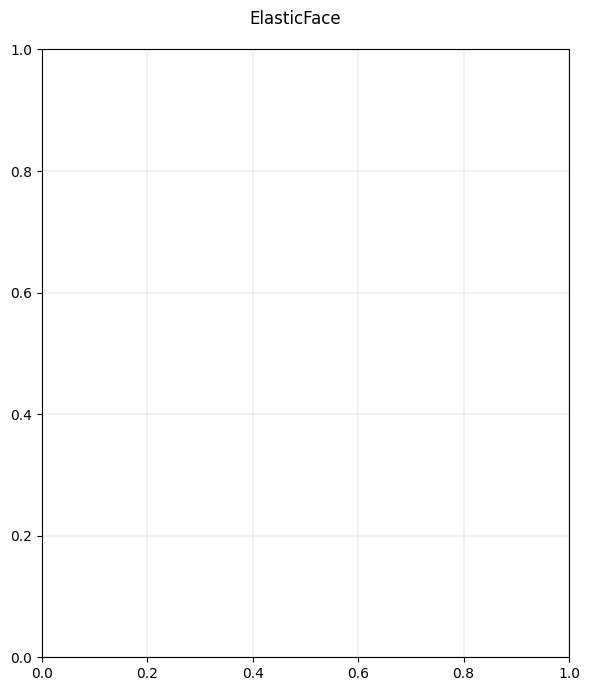

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)

# Title
# fig.suptitle(f"Mean image quality and standard deviation using {face_extractor}")
fig.suptitle(f"{face_extractor}")
labels = ["Original", "Reconstructed Unprotected", "Reconstructed PEMIU 16",
          "Reconstructed PEMIU 32", "Reconstructed PEMIU 64", "Reconstructed PEMIU 128"]
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
sns.barplot(data=df_image_quality_arcface[df_image_quality_arcface.columns[pd.Series(df_image_quality_arcface.columns).str.startswith('quality')]], 
            ax=ax, 
            estimator=np.mean, errorbar=('sd'), capsize=.2)
ax.set(ylabel="SER-FIQ image quality score")
ax.set_xticklabels(labels, rotation=70)
plt.ylim([0.4, 0.9])
plt.savefig(f'{plt_savepath}03_05_image_quailty_mean_std.svg', bbox_inches='tight')
plt.show()

In [131]:
def get_original_image(filename):
    return f"../data/lfw_align/{'_'.join(filename.split('_')[:-1])}/{filename}.png"

def get_reconstructed_image(filename):
    path = f"{experiment_10_path}sample_images_unprotected"
    return f"{path}/{filename}_model4_unprotected.png"

def get_pemiu_image(filename, blocksize):
    path = f"{experiment_10_path}sample_images_pemiu{blocksize}"
    return f"{path}/{filename}_model4_pemiu{blocksize}.png"

def get_cos_sim(filename, blocksize=False):
    if blocksize:
        #return format(round(df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
        return format(round(df_cos_sim_all[df_cos_sim_all['filename'] == f'{filename}'][f'cos_sim_pemiu{blocksize}_vs_real'].tolist()[0], 2), '.2f')
    else:
        #return format(round(df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_unprotected'].tolist()[0], 2), '.2f')
        return format(round(df_cos_sim_all[df_cos_sim_all['filename'] == f'{filename}'][f'cos_sim_reconstructed_vs_real'].tolist()[0], 2), '.2f')

def get_gender_prediction(filename, blocksize):
    gender_pred = f"{df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]}¹"
    
    if str(gender_pred)[:3] == 'nan':
        gender_pred = f"{df_gender_pred_th100_predicted_labels[df_gender_pred_th100_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]}¹"
    
    if str(gender_pred)[:3] == 'nan' and filename in df_gender_pred_from_predicted_labels['filename'].tolist():
        gender_pred = f"{df_gender_pred_from_predicted_labels[df_gender_pred_from_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_sigmoid'].tolist()[0]}²"
       
    if str(gender_pred)[:3] == 'nan':
        gender_pred = f"{df_insightface_prediction[df_insightface_prediction['filename'] == f'{filename}'][f'gender_insightface_img_pemiu_{blocksize}'].tolist()[0]}³"

    return gender_pred

def get_gender(filename):
    return df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'gender_official'].tolist()[0]

def get_gender_color(gender: str):
    return 'skyblue' if gender[:1] == 'M' else 'lightpink'
    
def display_image(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    if display_title:
        ax[0].set_title(f"Original", pad=10)
        ax[1].set_title("Reconstructed", pad=10)
        ax[2].set_title("Pemiu 16", pad=10)
    
    gender_color_prediction ='skyblue' if get_gender_prediction(filename, '16') == 'M' else 'lightpink'
    gender_color ='skyblue' if get_gender(filename) == 'M' else 'lightpink'
    
    # Display cosine similarity score
    ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[0].text(140, 150, get_gender(filename), fontsize=14, c=gender_color, bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '16'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    if str(get_gender_prediction(filename, '16')) != 'nan':
        ax[2].text(3,105, get_gender_prediction(filename, '16'), fontsize=14, c=get_gender_color(get_gender_prediction(filename, '16')), bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_original_image(filename)))
    ax[1].imshow(mpimg.imread(get_reconstructed_image(filename)))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "16")))
     
    for x in range(0, 3):
        ax[x].axis('off')
        
def display_image_pemiu(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    titles = ["Pemiu 32", "Pemiu 64", "Pemiu 128"]
    if display_title:
        for idx, title in enumerate(titles):
            ax[idx].set_title(title, pad=10)
    
    # Cos sim display
    ax[0].text(82, 105, get_cos_sim(filename, '32'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename, '64'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '128'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    # Gender prediction
    if str(get_gender_prediction(filename, '32')) != 'nan':
        ax[0].text(3,105, get_gender_prediction(filename, '32'), fontsize=14, 
                   c=get_gender_color(get_gender_prediction(filename, '32')), bbox=dict(facecolor='black', alpha=0.5))
    if str(get_gender_prediction(filename, '64')) != 'nan':
        ax[1].text(3,105, get_gender_prediction(filename, '64'), fontsize=14, 
                   c=get_gender_color(get_gender_prediction(filename, '64')), bbox=dict(facecolor='black', alpha=0.5))
    if str(get_gender_prediction(filename, '128')) != 'nan':
        ax[2].text(3,105, get_gender_prediction(filename, '128'), fontsize=14, 
                   c=get_gender_color(get_gender_prediction(filename, '128')), bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_pemiu_image(filename, "32")))
    ax[1].imshow(mpimg.imread(get_pemiu_image(filename, "64")))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "128")))
     
    for x in range(0, 3):
        ax[x].axis('off')

In [132]:
get_gender_color('M²')

'skyblue'

### Visual inspection of images reconstructed from PEMIU enhanced templates

In [133]:
# Create dataframe holding filenames of PEMIU enhanced recontructions that pass FMR100_TH
filenames_pass_th1000_df = pd.DataFrame(df_gender_pred_th100_predicted_labels[df_gender_pred_th100_predicted_labels['cos_sim_bonafide_synthesized_pemiu16_normalized'] > 0.34])
filenames_pass_th1000 = []
for i in range(len(df_gender_pred_th1000_predicted_labels)):
    if df_gender_pred_th100_predicted_labels.iloc[i]['gender_official'] == df_gender_pred_th100_predicted_labels.iloc[i]['pred_fromimg_16_svm_poly']:
        filenames_pass_th100.append(df_gender_pred_th1000_predicted_labels.iloc[i]['filename'])
# Sort by greatest cos_sim
filenames_pass_th100_df.sort_values(by="cos_sim_bonafide_synthesized_pemiu16_normalized", axis=0, ascending=False, inplace=True)

NameError: name 'filenames_pass_th100' is not defined

In [134]:
# df_gender_pred_from_predicted_labels[f'pred_fromimg_32_svm_poly'].tolist()

In [135]:
df_gender_pred_from_predicted_labels[df_gender_pred_from_predicted_labels['filename'] == f'Amer_al-Saadi_0001'][f'pred_fromimg_32_svm_poly']

Series([], Name: pred_fromimg_32_svm_poly, dtype: object)

In [136]:
df_gender_pred_from_predicted_labels[df_gender_pred_from_predicted_labels['filename'] == 'Aaron_Eckhart_0001']

filename  img_original_quality  \
0  Aaron_Eckhart_0001              0.785188   

                                     pemiu16_fromimg  \
0  experiments/experiment_10_elastic/embeddings_p...   

                                     pemiu32_fromimg  \
0  experiments/experiment_10_elastic/embeddings_p...   

                                     pemiu64_fromimg  \
0  experiments/experiment_10_elastic/embeddings_p...   

                                    pemiu128_fromimg  \
0  experiments/experiment_10_elastic/embeddings_p...   

                                      pemiu0_fromimg  \
0  experiments/experiment_10_elastic/embeddings_u...   

                                             pemiu16  \
0  ../data/lfw_align_embeddings_elastic_pemiu16/A...   

                                             pemiu32  \
0  ../data/lfw_align_embeddings_elastic_pemiu32/A...   

                                             pemiu64  ...  \
0  ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   

  pred_fromembedding_64_svm_poly pred_fromembedding_128_svm_poly  \
0                              M                               M   

  pred_fromembedding_16_svm_rbf  pred_fromembedding_32_svm_rbf  \
0                             M                              M   

   pred_fromembedding_64_svm_rbf  pred_fromembedding_128_svm_rbf  \
0                              M                               M   

   pred_fromembedding_16_svm_sigmoid  pred_fromembedding_32_svm_sigmoid  \
0                                  M                                  F   

   pred_fromembedding_64_svm_sigmoid pred_fromembedding_128_svm_sigmoid  
0                                  M                                  M  

[1 rows x 51 columns]

In [137]:
filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'M']['filename']

5           Aaron_Sorkin_0001
7       Abbas_Kiarostami_0001
31          Adam_Kennedy_0001
86             Alan_Ball_0002
107         Albert_Costa_0005
                ...          
5621     William_Ford_Jr_0007
5634      William_Nessen_0001
5682         Yann_Martel_0001
5699        Yoon_Jin-Sik_0001
5740           Ziwang_Xu_0001
Name: filename, Length: 284, dtype: object

In [138]:
df_insightface_prediction

Unnamed: 0                 filename  \
0               0       Aaron_Eckhart_0001   
1               1         Aaron_Guiel_0001   
2               2     Aaron_Patterson_0001   
3               3       Aaron_Peirsol_0001   
4               4       Aaron_Peirsol_0002   
...           ...                      ...   
13224       13224      Zorica_Radovic_0001   
13225       13225      Zulfiqar_Ahmed_0001   
13226       13226        Zumrati_Juma_0001   
13227       13227     Zurab_Tsereteli_0001   
13228       13228  Zydrunas_Ilgauskas_0001   

                                            img_original  \
0      ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...   
1      ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...   
2      ../data/lfw_align/Aaron_Patterson/Aaron_Patter...   
3      ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
4      ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
...                                                  ...   
13224  ../data/lfw_align/Zorica_Radovic/Zorica_Radovi...   
13225  ../data/lfw_align/Zulfiqar_Ahmed/Zulfiqar_Ahme...   
13226  ../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...   
13227  ../data/lfw_align/Zurab_Tsereteli/Zurab_Tseret...   
13228  ../data/lfw_align/Zydrunas_Ilgauskas/Zydrunas_...   

                                       img_reconstructed  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_16  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_32  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_64  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_fa

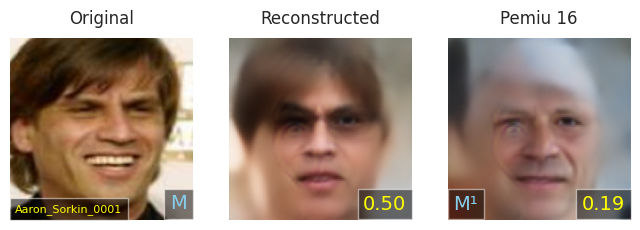

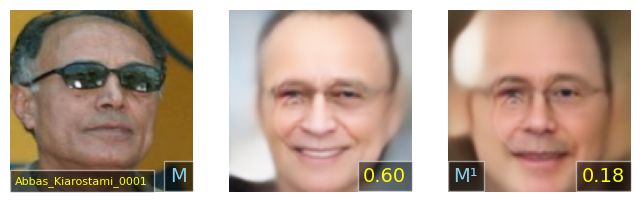

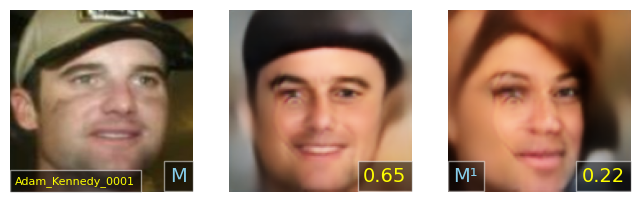

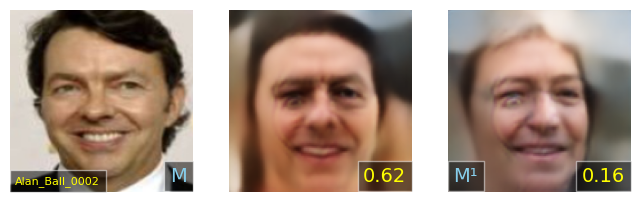

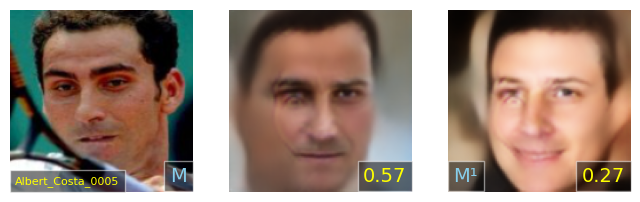

In [139]:
# Highest cos_sim for male subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'M']['filename']):
    if index == 0:
        display_image(name, display_title=True)
    elif index < 5:
        display_image(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_06_{index}_visual_inspection_male_real_reconstrcuted_pemiu16.svg', bbox_inches='tight')

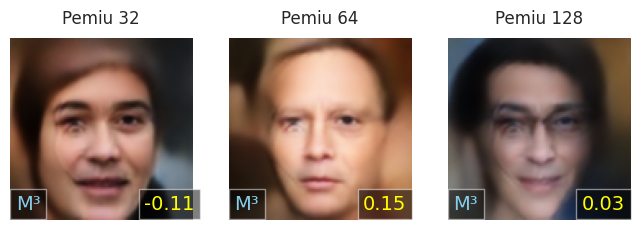

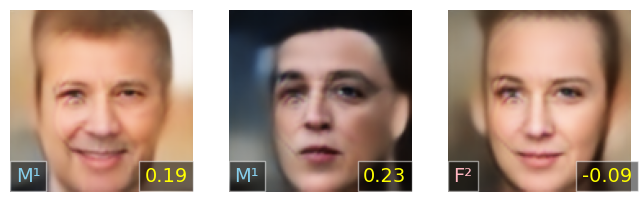

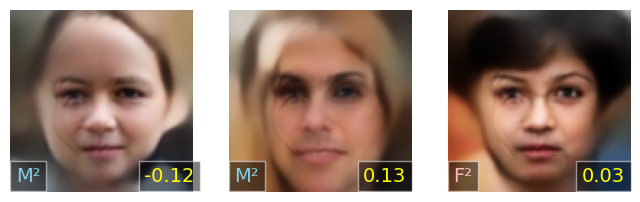

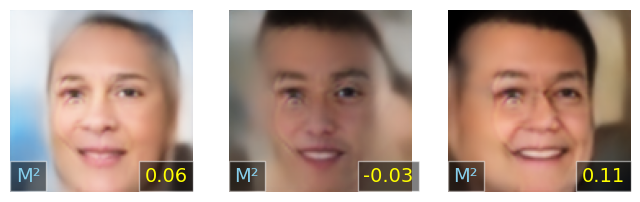

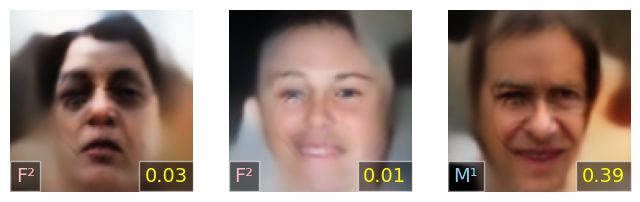

In [140]:
# Highest cos_sim for male subjects cont.
for index, name in enumerate(filenames_pass_th1000_df['filename']):
    if index == 0:
        display_image_pemiu(name, display_title=True)
    elif index < 5:
        display_image_pemiu(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_07_{index}_visual_inspection_male_pemiu_32_64_128.svg', bbox_inches='tight')

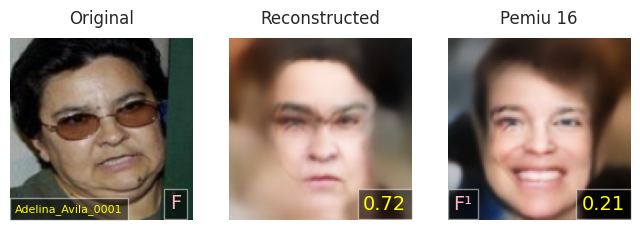

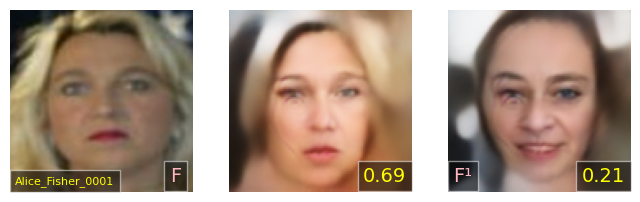

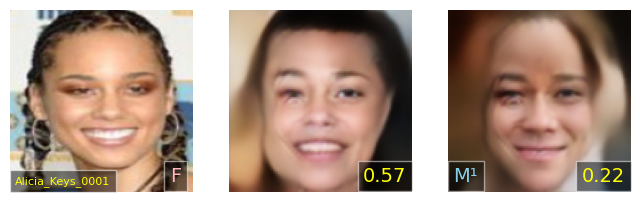

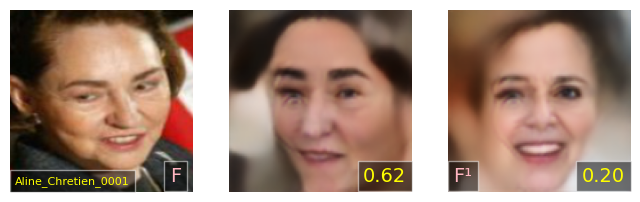

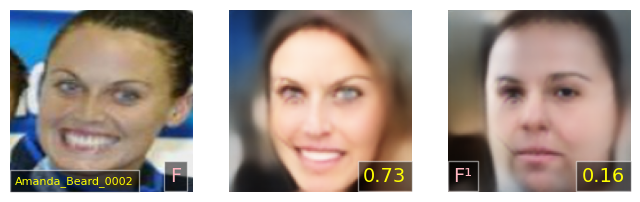

In [141]:
# Highest cos_sim for female subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'F']['filename']):
    if index == 0:
        display_image(name, True)
    elif index < 5:
        display_image(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_08_{index}_visual_inspection_female_real_reconstrcuted_pemiu16.svg', bbox_inches='tight')

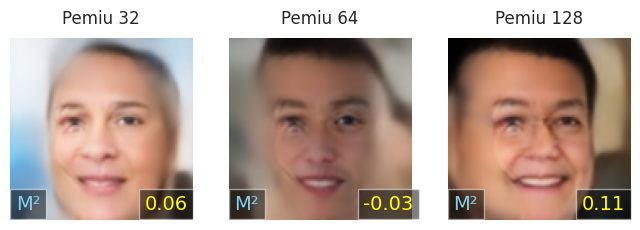

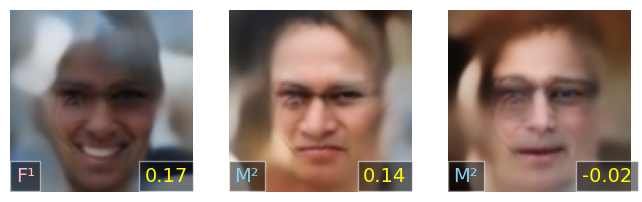

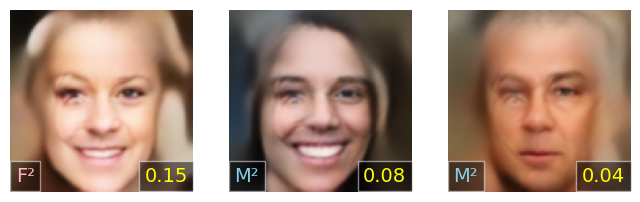

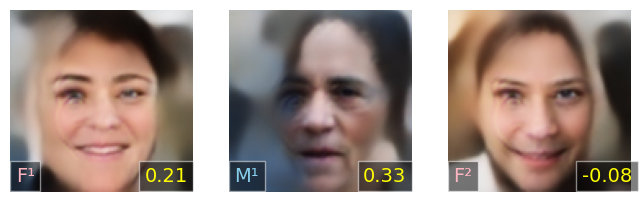

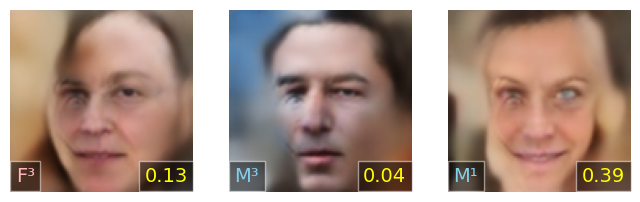

In [142]:
# Highest cos_sim for female subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'F']['filename']):
    if index == 0:
        display_image_pemiu(name, True)
    elif index < 5:
        display_image_pemiu(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_09_{index}_visual_inspection_female_pemiu_32_64_128.svg', bbox_inches='tight')

---

## 4. Attribute prediction (gender) on PEMIU enhanced embeddings

- Dataset: LFW (13.233 images)
- Labels (M/F) from official source

Prediction using
1. KNN on embedding
2. SVM on embedding
3. InsightFace on synthesized face images

### Gender distribution of original LFW dataset 

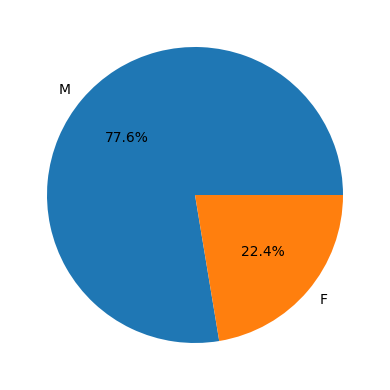

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4), tight_layout = True)
# fig.suptitle("Gender distribution of original LFW dataset")
num_m = len(df_pairs_gender[df_pairs_gender["gender_official"]=="M"])
num_f = len(df_pairs_gender[df_pairs_gender["gender_official"]=="F"])
plt.pie([num_m, num_f], labels=['M', 'F'], autopct='%1.1f%%')
plt.savefig(f'{plt_savepath}04_01_gender_distribution_lfw_original.svg', bbox_inches='tight')
plt.show()

### Data preparation

For evaluation the LFW dataset is used, consisting of 13,233 samples. The original gender distribution of the LFW dataset is 77.6% male.

Data preparation
1. The official list of gender labels downloaded from the LFW website is missing four samples. Those four samples are dropped from the dataset.
2. The best sample for each identity is chosen using SER-FIQ Face Image Quality Assessment. We reduce the dataset to include only one sample per identity: 5,749 samples.
3. The dataset contains 1,471 female and 4,378 male identities. This gender unbalance negatively influences the training results. Therefore, we reduce the number of male identities to match the amount of female identities. This yields a dataset containing 2,942 identities.
4. We sort the dataset to alternate between one male and one female sample to make sure that in each k-fold, we always have a balanced set of samples in regard to gender.

### Setup

ML algorithms:
- KNN
- SVM: Poly
- SVM: RBF
- SVM: Sigmoid

Dataset:
- LFW
- Balanced for gender equality

Training:
- Model is trained using the corresponding embeddings, e.g. for PEMIU blocksize 16, the training and testing is performed using embeddings of blocksize 16

Evaluation method:
- From embedding: Evaluation from unprotected and privacy enhanced (PEMIU) embeddings
- From image: Evaluation on embeddings created from reconstrcuted images produced from unprotected and privacy enhanced (PEMIU) embeddings


### Attribute prediction using ML and k-fold cross validation

Workflow:
- Introduce k-fold cross validation with 10 folds
- Calculate arithmetic mean as final result
- Only one sample per identity: Best quality
- Include standard deviation ("_std")

In [56]:
# From embedding
df_gender_pred_cv_from_embedding.loc[0, ['blocksize']] = 'Unprotected'
# df_gender_pred_cv_from_embedding

In [57]:
df_gender_pred_cv_from_img.loc[0, ['blocksize']] = 'Unprotected'


display = pd.DataFrame()

display['blocksize'] = df_gender_pred_cv_from_img['blocksize']
display['knn'] =  df_gender_pred_cv_from_img['knn_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['knn_std'] = df_gender_pred_cv_from_img['knn_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['poly'] = df_gender_pred_cv_from_img['svm_poly_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['poly_std'] = df_gender_pred_cv_from_img['svm_poly_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['rbf'] = df_gender_pred_cv_from_img['svm_rbf_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['rbf_std'] = df_gender_pred_cv_from_img['svm_rbf_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['sigmoid'] = df_gender_pred_cv_from_img['svm_sigmoid_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['sigmoid_std'] = df_gender_pred_cv_from_img['svm_sigmoid_std'].apply(lambda x: f"{format(round(x, 2), '.2f')}")
display
#df_gender_pred_cv_from_img

blocksize      knn knn_std     poly poly_std      rbf rbf_std  sigmoid  \
0  Unprotected  0.68 ±    0.04,  0.85 ±     0.02,  0.88 ±    0.02,  0.84 ±    
1           16  0.49 ±    0.03,  0.52 ±     0.02,  0.52 ±    0.03,  0.51 ±    
2           32  0.50 ±    0.02,  0.52 ±     0.02,  0.55 ±    0.02,  0.54 ±    
3           64  0.52 ±    0.02,  0.57 ±     0.01,  0.58 ±    0.03,  0.57 ±    
4          128  0.54 ±    0.03,  0.64 ±     0.03,  0.64 ±    0.02,  0.63 ±    

  sigmoid_std  
0        0.02  
1        0.03  
2        0.03  
3        0.03  
4        0.03

In [58]:
df_gender_pred_cv_from_img

blocksize  knn_mean  knn_std  svm_poly_mean  svm_poly_std  svm_rbf_mean  \
0  Unprotected    0.6791   0.0353         0.8474        0.0189        0.8787   
1           16    0.4949   0.0308         0.5163        0.0234        0.5190   
2           32    0.5014   0.0226         0.5221        0.0241        0.5486   
3           64    0.5224   0.0167         0.5673        0.0103        0.5795   
4          128    0.5364   0.0302         0.6367        0.0252        0.6370   

   svm_rbf_std  svm_sigmoid_mean  svm_sigmoid_std  
0       0.0215            0.8447           0.0238  
1       0.0256            0.5133           0.0281  
2       0.0243            0.5418           0.0272  
3       0.0256            0.5741           0.0257  
4       0.0239            0.6309           0.0251

### Attack scenario: Predict gender of PEMIU protected embeddings

- Train model on images reconstructed from unprotected embeddings
- Test model on images created from PEMIU protected embeddings
- For each identity, only the sample with the highest image quality (SER_FIQ) is used for prediction

In [53]:
df_gender_pred_from_img.iloc[:, 0:5].apply(lambda x:  round(x, 5)*100)

blocksize     knn  svm_poly  svm_rbf  svm_sigmoid
0       1600  49.320    49.150   48.946       48.776
1       3200  49.626    50.068   50.510       50.884
2       6400  51.700    53.025   53.195       53.025
3      12800  56.628    61.353   61.013       59.585

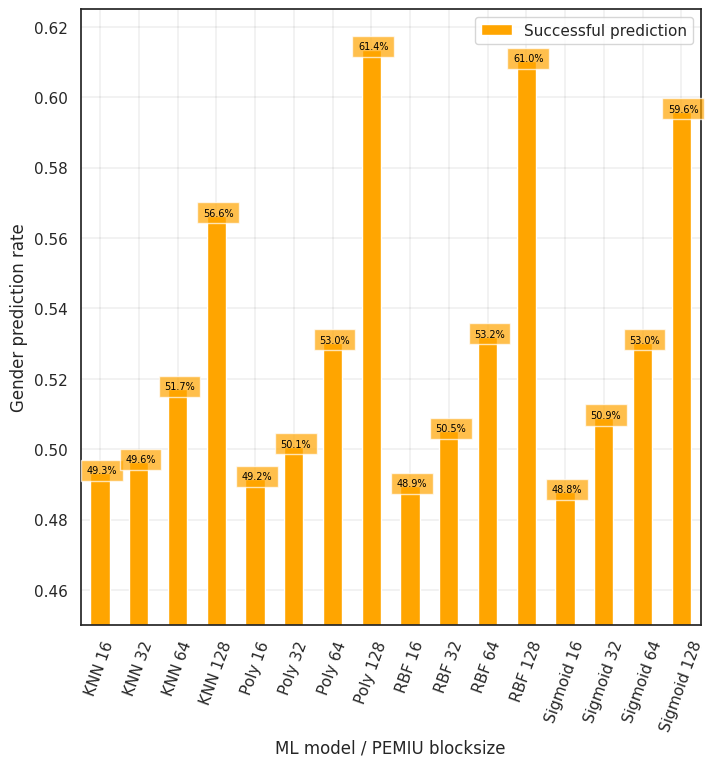

In [60]:
# Successfully predicted samples

df = df_gender_pred_from_img.T.iloc[1:, :]
df.reset_index()
df.index.name = 'Model'
df_numbers = df.to_numpy().flatten()
df_numbers = pd.DataFrame(df_numbers)
df_numbers.index.name = 'Model'
df_numbers.rename({0: 'Successful prediction'}, axis=1, inplace=True)

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_numbers.plot(kind='bar', color=['orange'], ax=ax, zorder=2, label=['Successful predictions'])
# df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Gender prediction rate')
# ax.set_title(f"Gender prediction attack on synthesized imagesusing {face_extractor}\n with a balanced dataset")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 16:
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f"{round(df_numbers['Successful prediction'].tolist()[index]*100, 1)}%", (x-0.2, y), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
plt.ylim([0.45, 0.625])
plt.savefig(f'{plt_savepath}04_02_gender_predict_ml_success_rate.svg', bbox_inches='tight')
plt.show()

### Attack: Predict gender of PEMIU protected embeddings, but only on samples where the synthesized image passes the FMR100 threshold

Workflow:
- Balance the dataset to include same amount of male and female samples
- Train model on unprotected templates and official gender labels
- Filter the dataset to only include the samples that pass the FMR100 threshold (meaning: where the cosine similarity is greater than 0.34)
- Predict labels only on filtered dataset

In [52]:
df_gender_pred_th100_from_img.iloc[:, 0:5].apply(lambda x: round(x, 5)*100)

blocksize     knn  svm_poly  svm_rbf  svm_sigmoid
0       1600  45.185    66.420   64.198       63.951
1       3200  45.633    69.340   65.954       65.241
2       6400  47.372    71.023   67.614       65.554
3      12800  51.503    76.441   73.116       71.206

In [53]:
possible_predictions_ml_eval = len(df_gender_pred_th100_predicted_labels)
print(f"Amount of possible predictions: {possible_predictions_ml_eval}")

Amount of possible predictions: 5748


In [54]:
# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
mask_predicted = df_gender_pred_th100_predicted_labels.columns.str.contains('pred_*')
for column in df_gender_pred_th100_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_gender_pred_th100_predicted_labels)):
        if df_gender_pred_th100_predicted_labels['gender_official'][index] == df_gender_pred_th100_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_gender_pred_th100_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_gender_pred_th100_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_gender_pred_th100_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

Model  Successful predictions  \
0                  pred_fromimg_16_knn                     183   
1                  pred_fromimg_32_knn                     256   
2                  pred_fromimg_64_knn                     667   
3                 pred_fromimg_128_knn                    1456   
4             pred_fromimg_16_svm_poly                     269   
5             pred_fromimg_32_svm_poly                     389   
6             pred_fromimg_64_svm_poly                    1000   
7            pred_fromimg_128_svm_poly                    2161   
8              pred_fromimg_16_svm_rbf                     260   
9              pred_fromimg_32_svm_rbf                     370   
10             pred_fromimg_64_svm_rbf                     952   
11            pred_fromimg_128_svm_rbf                    2067   
12         pred_fromimg_16_svm_sigmoid                     259   
13         pred_fromimg_32_svm_sigmoid                     366   
14         pred_fromimg_64_svm_sigmoid                     923   
15        pred_fromimg_128_svm_sigmoid                    2013   
16           pred_fromembedding_16_knn                     129   
17           pred_fromembedding_32_knn                     200   
18           pred_fromembedding_64_knn                     484   
19          pred_fromembedding_128_knn                    1057   
20      pred_fromembedding_16_svm_poly                     280   
21      pred_fromembedding_32_svm_poly                     397   
22      pred_fromembedding_64_svm_poly                    1111   
23     pred_fromembedding_128_svm_poly                    2463   
24       pred_fromembedding_16_svm_rbf                     265   
25       pred_fromembedding_32_svm_rbf                     383   
26       pred_fromembedding_64_svm_rbf                    1090   
27      pred_fromembedding_128_svm_rbf                    2358   
28   pred_fromembedding_16_svm_sigmoid                     268   
29   pred_fromembedding_32_svm_sigmoid                     392   
30   pred_fromembedding_64_svm_sigmoid                    1011   
31  pred_fromembedding_128_svm_sigmoid                    2222   

    Possible predictions  
0                    405  
1                    561  
2                   1408  
3                   2827  
4                    405  
5                    561  
6                   1408  
7                   2827  
8                    405  
9                    561  
10                  1408  
11                  2827  
12                   405  
13                   561  
14                  1408  
15                  2827  
16                   405  
17                   561  
18                  1408  
19                  2827  
20                   405  
21                   561  
22                  1408  
23                  2827  
24                   405  
25                   561  
26                  1408  
27                  2827  
28                   405  
29                   561  
30                  1408  
31                  2827

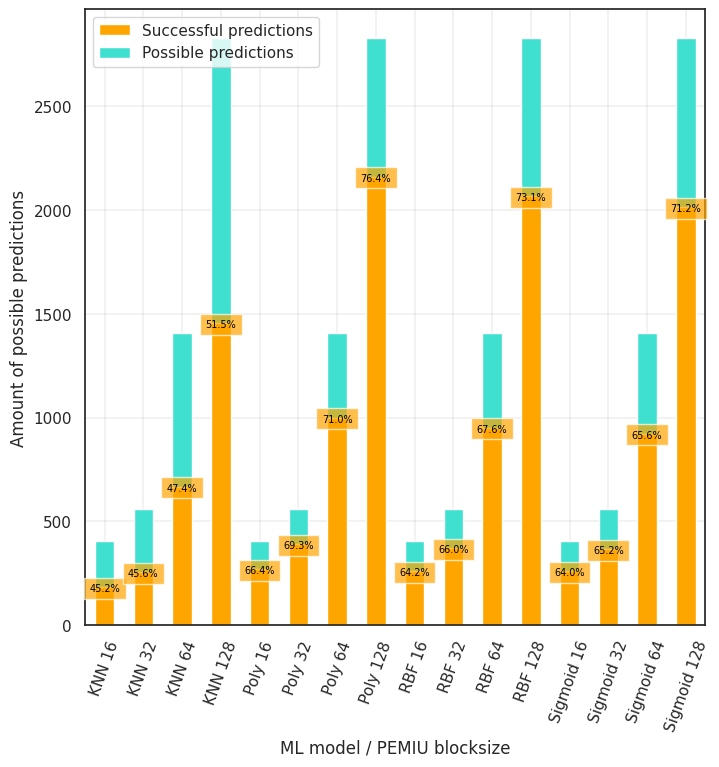

In [64]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack on synthesized images using {face_extractor}\nConsidering only identities, where the reconstrcuted image passes the FMR100 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}%', (x-0.25, y-20), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)

plt.savefig(f'{plt_savepath}04_03_gender_predict_ml_success_rate_th100.svg', bbox_inches='tight')
plt.show()

In [65]:
possible_predictions_ml_eval
[print(f"Percentage of possible predictions per block size: {round((x / possible_predictions_ml_eval * 100), 2)}%") for x in df_results_correct_prediction['Possible predictions'][0:4].tolist()]


Percentage of possible predictions per block size: 7.05%
Percentage of possible predictions per block size: 9.76%
Percentage of possible predictions per block size: 24.5%
Percentage of possible predictions per block size: 49.18%


[None, None, None, None]

### Attack: Predict gender of PEMIU protected embeddings, but only on samples, where the synthesized image passes the FMR1000 threshold

- Threshold now FMR1000: 0.4

In [51]:
df_gender_pred_th1000_from_img.apply(lambda x: round(x, 5)*100)

blocksize     knn  svm_poly  svm_rbf  svm_sigmoid
0       1600  33.333    85.714   95.238      100.000
1       3200  48.780    82.927   73.171       74.390
2       6400  52.421    75.368   72.000       71.158
3      12800  55.775    81.138   78.410       76.088

In [67]:
mask_predicted = df_gender_pred_th1000_predicted_labels.columns.str.contains('pred_*')

# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
for column in df_gender_pred_th1000_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_gender_pred_th1000_predicted_labels)):
        if df_gender_pred_th1000_predicted_labels['gender_official'][index] == df_gender_pred_th1000_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)
    # df_results_correct_prediction[column] = correct_predictions

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_gender_pred_th1000_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_gender_pred_th1000_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_gender_pred_th1000_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

Model  Successful predictions  \
0                  pred_fromimg_16_knn                       7   
1                  pred_fromimg_32_knn                      40   
2                  pred_fromimg_64_knn                     249   
3                 pred_fromimg_128_knn                     961   
4             pred_fromimg_16_svm_poly                      18   
5             pred_fromimg_32_svm_poly                      68   
6             pred_fromimg_64_svm_poly                     358   
7            pred_fromimg_128_svm_poly                    1398   
8              pred_fromimg_16_svm_rbf                      20   
9              pred_fromimg_32_svm_rbf                      60   
10             pred_fromimg_64_svm_rbf                     342   
11            pred_fromimg_128_svm_rbf                    1351   
12         pred_fromimg_16_svm_sigmoid                      21   
13         pred_fromimg_32_svm_sigmoid                      61   
14         pred_fromimg_64_svm_sigmoid                     338   
15        pred_fromimg_128_svm_sigmoid                    1311   
16           pred_fromembedding_16_knn                       5   
17           pred_fromembedding_32_knn                      32   
18           pred_fromembedding_64_knn                     197   
19          pred_fromembedding_128_knn                     737   
20      pred_fromembedding_16_svm_poly                      15   
21      pred_fromembedding_32_svm_poly                      62   
22      pred_fromembedding_64_svm_poly                     390   
23     pred_fromembedding_128_svm_poly                    1576   
24       pred_fromembedding_16_svm_rbf                      15   
25       pred_fromembedding_32_svm_rbf                      62   
26       pred_fromembedding_64_svm_rbf                     374   
27      pred_fromembedding_128_svm_rbf                    1490   
28   pred_fromembedding_16_svm_sigmoid                      16   
29   pred_fromembedding_32_svm_sigmoid                      63   
30   pred_fromembedding_64_svm_sigmoid                     349   
31  pred_fromembedding_128_svm_sigmoid                    1410   

    Possible predictions  
0                     21  
1                     82  
2                    475  
3                   1723  
4                     21  
5                     82  
6                    475  
7                   1723  
8                     21  
9                     82  
10                   475  
11                  1723  
12                    21  
13                    82  
14                   475  
15                  1723  
16                    21  
17                    82  
18                   475  
19                  1723  
20                    21  
21                    82  
22                   475  
23                  1723  
24                    21  
25                    82  
26                   475  
27                  1723  
28                    21  
29                    82  
30                   475  
31                  1723

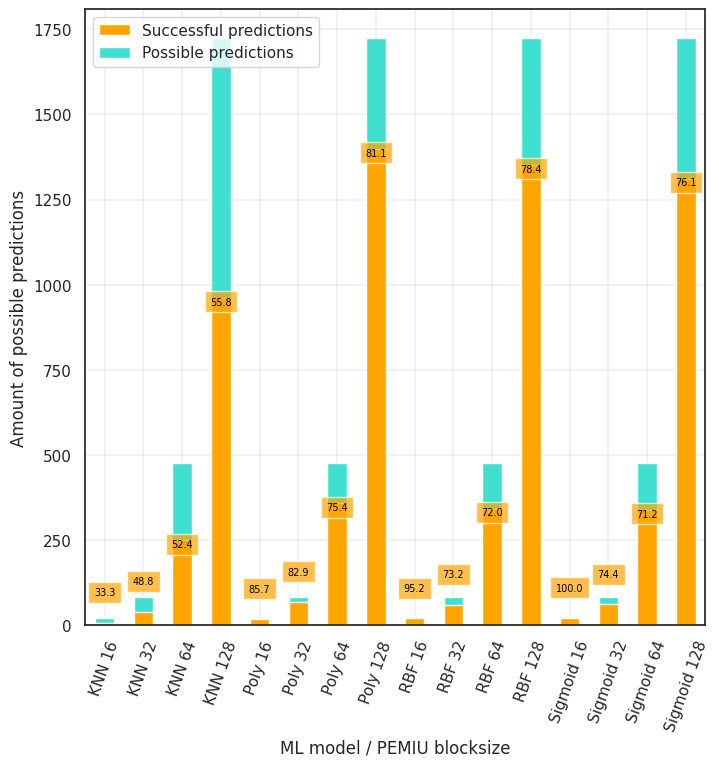

In [68]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack on synthesized images using {face_extractor}\nConsidering only identities, where the reconstrcuted image passes the FMR1000 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        # Form an offset to place the label above columns when columns are very small
        offset = 0
        if y < 115:
            offset = +80
        else:
            offset = -20
        ax.annotate(f'{percentage}', (x-0.25, y+offset), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))

# ax.axhline(df_genders['gender_official'].value_counts().tolist()[0])
plt.savefig(f'{plt_savepath}04_04_gender_predict_ml_success_rate_th1000.svg', bbox_inches='tight')
plt.show()

### Predicted gender distribution for PEMIU enhanced embeddings
- Dataset: Genders evenly distributed 50/50
- Only best quality sample per identity

In [69]:
# Get a mask for columns starting with 'pred_fromimg_' / 'pred_fromembedding_'
mask_fromimg = df_gender_pred_from_predicted_labels.columns.str.contains('pred_fromimg_*')
mask_fromembedding = df_gender_pred_from_predicted_labels.columns.str.contains('pred_fromembedding_*')

# Count male and female samples per evaluation column
gender_count_fromimg = {}
gender_count_fromimg['genders_official'] = df_gender_pred_from_predicted_labels['gender_official'].value_counts().tolist()
for column in df_gender_pred_from_predicted_labels.loc[:, mask_fromimg]:
    gender_count_fromimg[column] = df_gender_pred_from_predicted_labels[column].value_counts().tolist()
# gender_count_fromimg

df_gender_count_fromimg = pd.DataFrame.from_dict(gender_count_fromimg, orient='columns')
df_gender_count_fromimg = df_gender_count_fromimg.rename(index={0: 'M', 1: 'F'}).T

df_gender_count_fromimg.index.name = 'Model'
df_gender_count_fromimg.reset_index(inplace=True)

df_gender_count_fromimg

Model     M     F
0               genders_official  1471  1471
1            pred_fromimg_16_knn  1948   994
2            pred_fromimg_32_knn  1889  1053
3            pred_fromimg_64_knn  1920  1022
4           pred_fromimg_128_knn  1951   991
5       pred_fromimg_16_svm_poly  2301   641
6       pred_fromimg_32_svm_poly  2288   654
7       pred_fromimg_64_svm_poly  2215   727
8      pred_fromimg_128_svm_poly  2082   860
9        pred_fromimg_16_svm_rbf  1861  1081
10       pred_fromimg_32_svm_rbf  1833  1109
11       pred_fromimg_64_svm_rbf  1756  1186
12      pred_fromimg_128_svm_rbf  1702  1240
13   pred_fromimg_16_svm_sigmoid  1820  1122
14   pred_fromimg_32_svm_sigmoid  1788  1154
15   pred_fromimg_64_svm_sigmoid  1739  1203
16  pred_fromimg_128_svm_sigmoid  1680  1262

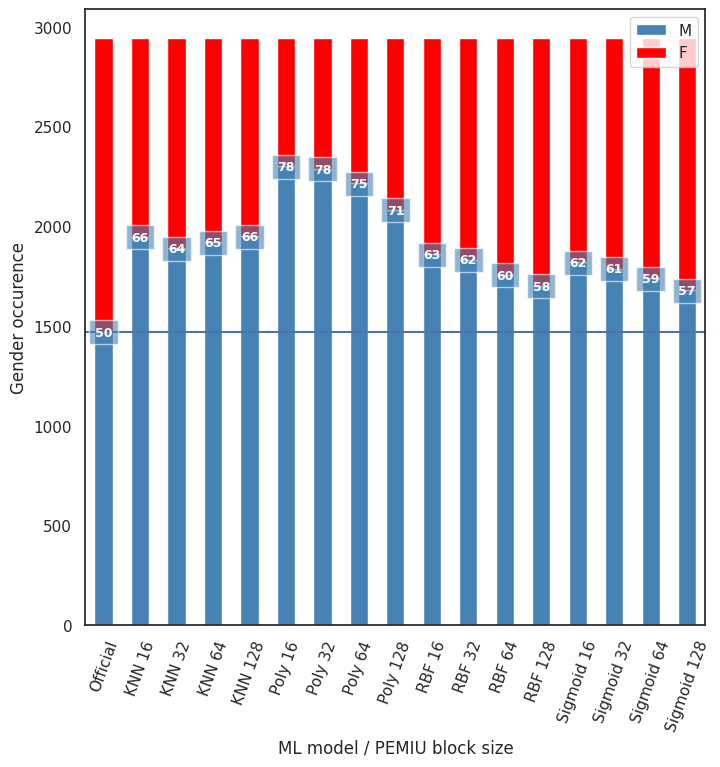

In [70]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128',]

#create stacked bar chart
ax = df_gender_count_fromimg.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
# ax.set_title("Distribution of predicted gender using different ML algorithms\n" \
#              f"on PEMIU enhanced embeddings using {face_extractor} at varying block sizes")
#ax.set_title(f"{face_extractor}")
ax.axhline(df_gender_count_fromimg.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 17:
        percent_male = df_gender_count_fromimg['M'][index]
        percent_total = df_gender_count_fromimg.iloc[1][1] + df_gender_count_fromimg.iloc[1][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.savefig(f'{plt_savepath}04_05_gender_predict_ml_gender_distribution.svg', bbox_inches='tight')
plt.show()

### Gender prediction using InsightFace model

### Benchmark for InsightFace gender prediction model

- Confusion matrix for gender prediction using InsightFace
- Test InsightFace gender prediction model on original LFW images and official labels

In [5]:
if_prediction_rate = []

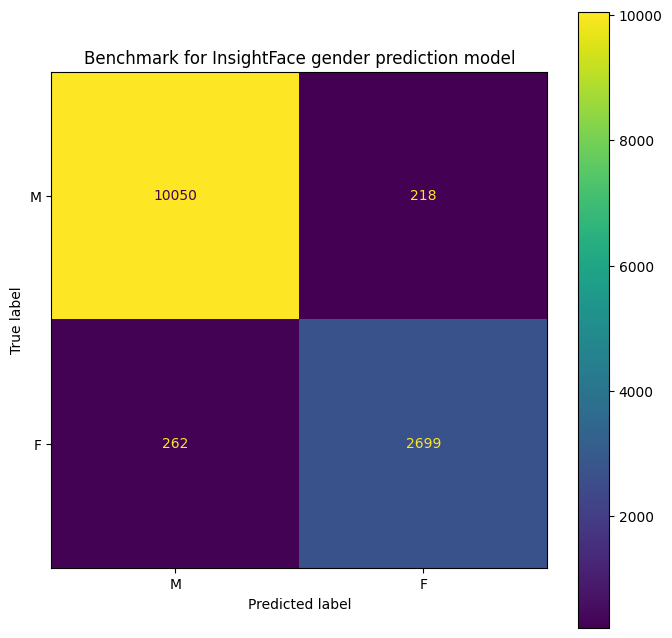

InsightFace false prediction rate: 3.66 %


In [6]:
cm = confusion_matrix(df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')

plt.title("Benchmark for InsightFace gender prediction model")

plt.show()

false_prediction_unmodified = []
for index, element in enumerate(df_pairs_gender['gender_official']):
    if not df_pairs_gender['gender_insightface'].iloc[index]:
        break
    if element != df_pairs_gender['gender_insightface'][index]:
        false_prediction_unmodified.append(element)
        
if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))

print(f"InsightFace false prediction rate: {if_prediction_rate[0]} %")

In [7]:
df_insightface_prediction.head()

Unnamed: 0              filename  \
0           0    Aaron_Eckhart_0001   
1           1      Aaron_Guiel_0001   
2           2  Aaron_Patterson_0001   
3           3    Aaron_Peirsol_0001   
4           4    Aaron_Peirsol_0002   

                                        img_original  \
0  ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...   
1  ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...   
2  ../data/lfw_align/Aaron_Patterson/Aaron_Patter...   
3  ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
4  ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   

                                   img_reconstructed  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_16  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_32  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_64  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                       img_pemiu_128 gender_official  \
0  ../recreate_icip2022_face_reconstruction/exper...               M   
1  ../recreate_icip2022_face_reconstruction/exper...               M   
2  ../recreate_icip2022_face_reconstruction/exper...               M   
3  ../recreate_icip2022_face_reconstruction/exper...               M   
4  ../recreate_icip2022_face_reconstruction/exper...               M   

  gender_insightface_img_original gender_insightface_img_reconstructed  \
0                               M                                    M   
1                               M                                    F   
2                               M                                    M   
3                               M                                    F   
4                               M                                    F   

  gender_insightface_img_pemiu_16 gender_insightface_img_pemiu_32  \
0                               F                               F   
1                               F                               F   
2                               F                               F   
3                               F                               F   
4                               M                               F   

  gender_insightface_img_pemiu_64 gender_insightface_img_pemiu_128  
0                               M                                F  
1                               F                                F  
2                               F                                F  
3                               M                                F  
4                               M                                F

In [8]:
df_insightface_prediction.columns.tolist()

['Unnamed: 0',
 'filename',
 'img_original',
 'img_reconstructed',
 'img_pemiu_16',
 'img_pemiu_32',
 'img_pemiu_64',
 'img_pemiu_128',
 'gender_official',
 'gender_insightface_img_original',
 'gender_insightface_img_reconstructed',
 'gender_insightface_img_pemiu_16',
 'gender_insightface_img_pemiu_32',
 'gender_insightface_img_pemiu_64',
 'gender_insightface_img_pemiu_128']

### InsightFace gender prediction on images synthesized from unprotected templates

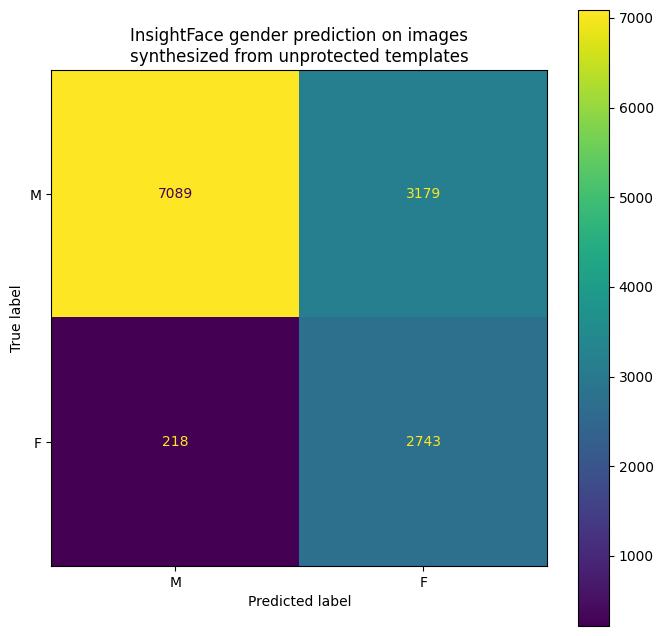

InsightFace false prediction rate: 25.67 %


In [9]:
cm = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction['gender_insightface_img_reconstructed'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')

plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")

plt.show()

false_prediction_unmodified = []
for index, element in enumerate(df_insightface_prediction['gender_official']):
    if element != df_insightface_prediction['gender_insightface_img_reconstructed'][index]:
        false_prediction_unmodified.append(element)
        
if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))
        
print(f"InsightFace false prediction rate: {if_prediction_rate[1]} %")

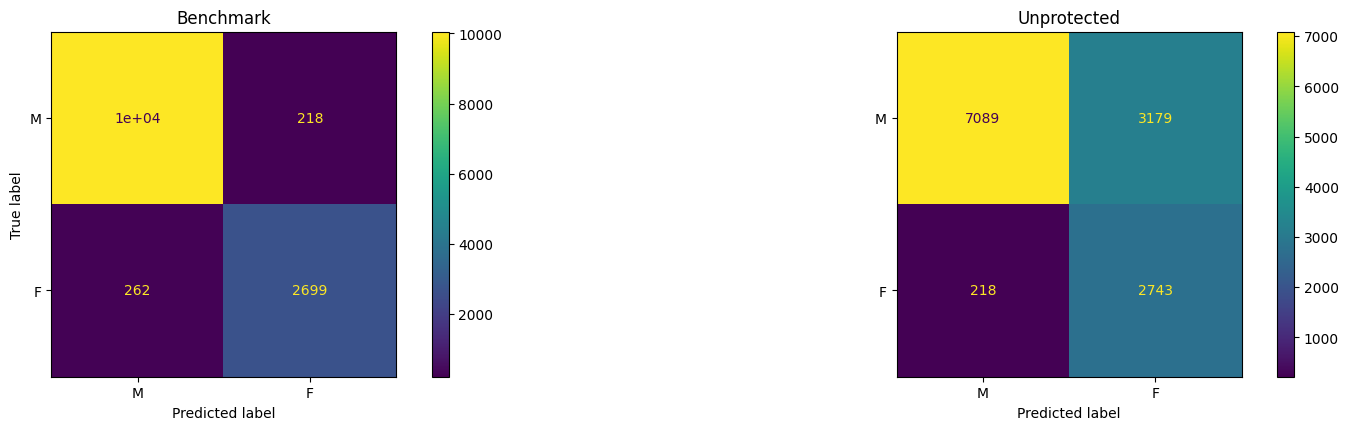

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
fig.subplots_adjust(top=0.8)
# Title
# fig.suptitle("InsightFace gender prediction on original images as benchmark\n" \
#              "and recontructed from unprotected embeddings")
#fig.suptitle(f"{face_extractor}")
for i, (title, ax) in enumerate(zip(["Benchmark", "Unprotected"], fig.get_axes())):
    if i == 0:
        cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_original'], labels=["M", "F"])
    else:
        cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_reconstructed'], labels=["M", "F"])
    disp = ConfusionMatrixDisplay(cf_matrix,
                              display_labels=["M", "F"])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f"{title}")
    #disp.im_.colorbar.remove()
    # disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

# plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")
#fig.colorbar(disp.im_, ax=axes)
plt.savefig(f'{plt_savepath}04_06_gender_predict_insightface_cm_benchmark_unprotected.svg', bbox_inches='tight')
plt.show()

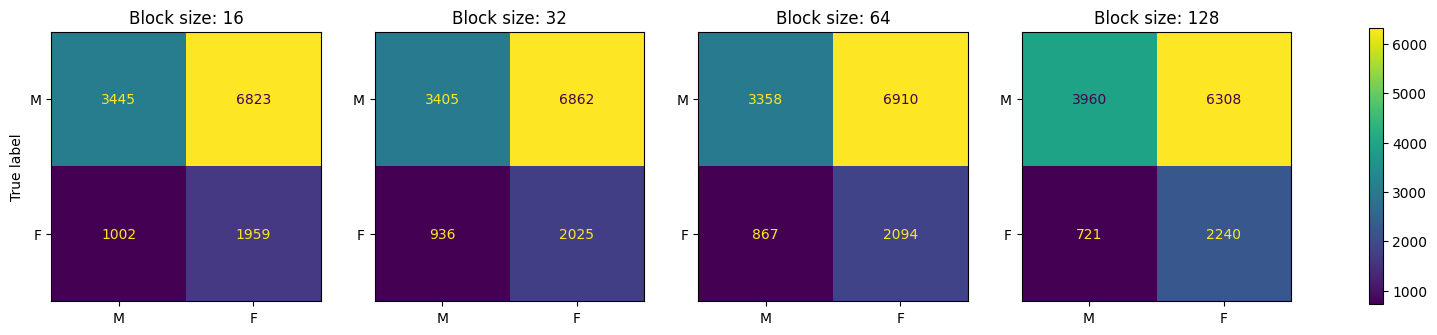

InsightFace false prediction rate: 59.13 %
InsightFace false prediction rate: 58.94 %
InsightFace false prediction rate: 58.77 %
InsightFace false prediction rate: 53.12 %


In [11]:
fig, axes = plt.subplots(1, 4, figsize = (20, 4))
fig.subplots_adjust(top=0.8)
# Title
# fig.suptitle("InsightFace gender prediction on images synthesized from PEMIU protected templates\n" \
#              "at varying block sizes")
#fig.suptitle(f"{face_extractor}")
for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_pemiu_{blocksize}'], labels=["M", "F"])
    disp = ConfusionMatrixDisplay(cf_matrix,
                              display_labels=["M", "F"])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f"Block size: {blocksize}")
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

# plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")
fig.colorbar(disp.im_, ax=axes)
plt.savefig(f'{plt_savepath}04_07_gender_predict_insightface_cm_pemiu.svg', bbox_inches='tight')
plt.show()

for i, blocksize in enumerate(block_sizes):
    false_prediction_unmodified = []
    for index, element in enumerate(df_insightface_prediction['gender_official']):
        if element != df_insightface_prediction[f'gender_insightface_img_pemiu_{blocksize}'][index]:
            false_prediction_unmodified.append(element)
    if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))
    print(f"InsightFace false prediction rate: {if_prediction_rate[i+2]} %")

In [12]:
if_prediction_rate

[3.66, 25.67, 59.13, 58.94, 58.77, 53.12]

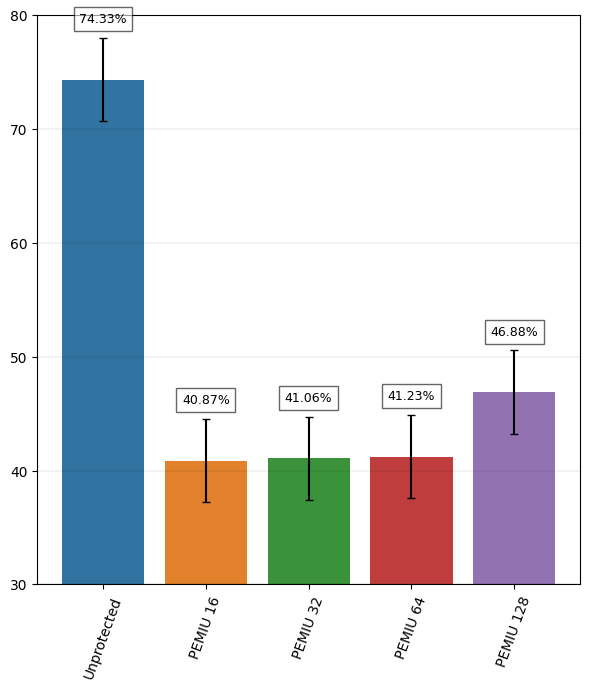

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)

# Title
# fig.suptitle(f"Gender prediction attack with InsightFace on reconstructed images using {face_extractor}:\n" \
#              "Success attack rate for unprotected and PEMIU enhanced at varying block sizes\n")
#fig.suptitle(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
df = pd.DataFrame(if_prediction_rate, ["Benchmark", "Unprotected", "PEMIU 16", "PEMIU 32", "PEMIU 64", "PEMIU 128"])
df = df.T

df = df.apply(lambda x: (x-100)*-1)

sns.barplot(data=df.iloc[:, 1:], 
            ax=ax)
ax.set_xticklabels(df.columns.tolist()[1:], rotation=70)

for index, p in enumerate(ax.patches):
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(f'{df.iloc[0].tolist()[index+1]}%', (x-0.4, y+5), ha='center', 
                fontweight='normal', fontsize=9, c='black', bbox=dict(facecolor='white', alpha=0.6)) 
    ax.errorbar(x=x-0.4, y=y, yerr=((df.iloc[0].tolist()[0] - 100) * -1), fmt="none", c="k", capsize=3)

plt.ylim([30, 80])
    
plt.savefig(f'{plt_savepath}04_08_gender_predict_insightface_success_rate.svg', bbox_inches='tight')
plt.show()

### Distribution of predicted gender with InsightFace

In [15]:
# Dataset that only contains (1) one sample per image, (2) balanced genders
# was also used for the distribution experiment performed with ML
df_gender_pred_from_predicted_labels.head()

filename  img_original_quality  \
0     Aaron_Eckhart_0001              0.785188   
77    Adelina_Avila_0001              0.846964   
1       Aaron_Guiel_0001              0.764814   
88     Adriana_Lima_0001              0.736330   
2   Aaron_Patterson_0001              0.737193   

                                      pemiu16_fromimg  \
0   experiments/experiment_10_elastic/embeddings_p...   
77  experiments/experiment_10_elastic/embeddings_p...   
1   experiments/experiment_10_elastic/embeddings_p...   
88  experiments/experiment_10_elastic/embeddings_p...   
2   experiments/experiment_10_elastic/embeddings_p...   

                                      pemiu32_fromimg  \
0   experiments/experiment_10_elastic/embeddings_p...   
77  experiments/experiment_10_elastic/embeddings_p...   
1   experiments/experiment_10_elastic/embeddings_p...   
88  experiments/experiment_10_elastic/embeddings_p...   
2   experiments/experiment_10_elastic/embeddings_p...   

                                      pemiu64_fromimg  \
0   experiments/experiment_10_elastic/embeddings_p...   
77  experiments/experiment_10_elastic/embeddings_p...   
1   experiments/experiment_10_elastic/embeddings_p...   
88  experiments/experiment_10_elastic/embeddings_p...   
2   experiments/experiment_10_elastic/embeddings_p...   

                                     pemiu128_fromimg  \
0   experiments/experiment_10_elastic/embeddings_p...   
77  experiments/experiment_10_elastic/embeddings_p...   
1   experiments/experiment_10_elastic/embeddings_p...   
88  experiments/experiment_10_elastic/embeddings_p...   
2   experiments/experiment_10_elastic/embeddings_p...   

                                       pemiu0_fromimg  \
0   experiments/experiment_10_elastic/embeddings_u...   
77  experiments/experiment_10_elastic/embeddings_u...   
1   experiments/experiment_10_elastic/embeddings_u...   
88  experiments/experiment_10_elastic/embeddings_u...   
2   experiments/experiment_10_elastic/embeddings_u...   

                                              pemiu16  \
0   ../data/lfw_align_embeddings_elastic_pemiu16/A...   
77  ../data/lfw_align_embeddings_elastic_pemiu16/A...   
1   ../data/lfw_align_embeddings_elastic_pemiu16/A...   
88  ../data/lfw_align_embeddings_elastic_pemiu16/A...   
2   ../data/lfw_align_embeddings_elastic_pemiu16/A...   

                                              pemiu32  \
0   ../data/lfw_align_embeddings_elastic_pemiu32/A...   
77  ../data/lfw_align_embeddings_elastic_pemiu32/A...   
1   ../data/lfw_align_embeddings_elastic_pemiu32/A...   
88  ../data/lfw_align_embeddings_elastic_pemiu32/A...   
2   ../data/lfw_align_embeddings_elastic_pemiu32/A...   

                                              pemiu64  ...  \
0   ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   
77  ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   
1   ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   
88  ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   
2   ../data/lfw_align_embeddings_elastic_pemiu64/A...  ...   

   pred_fromembedding_64_svm_poly pred_fromembedding_128_svm_poly  \
0                               M                               M   
77                              M                               M   
1                               M                               M   
88                              M                               F   
2                               M                               M   

   pred_fromembedding_16_svm_rbf  pred_fromembedding_32_svm_rbf  \
0                              M                              M   
77                             F                              M   
1                              F                              M   
88                             F                              M   
2                              M                              M   

    pred_fromembedding_64_svm_rbf  pred_fromembedding_128_svm_rbf  \
0                               M                     

In [16]:
# Dataset contains all insightface predictions
df_insightface_prediction.shape

(13229, 15)

In [56]:
df_insightface_prediction_reduced = df_gender_pred_from_predicted_labels.merge(df_insightface_prediction, on=['filename'], how='left')
df_insightface_prediction_reduced[['gender_official_x', 'gender_official_y']]

gender_official_x gender_official_y
0                    M                 M
1                    F                 F
2                    M                 M
3                    F                 F
4                    M                 M
...                ...               ...
2937                 F                 F
2938                 M                 M
2939                 F                 F
2940                 M                 M
2941                 F                 F

[2942 rows x 2 columns]

In [57]:
# InsightFace prediction rate for LFW balanced
length_frame = len(df_insightface_prediction_reduced)
correct_if = []
for blocksize in block_sizes:
    correct_if.append(len(df_insightface_prediction_reduced[df_insightface_prediction_reduced[f'gender_insightface_img_pemiu_{blocksize}'] == df_insightface_prediction_reduced['gender_official_x']]))

#length_frame
[round(x/length_frame, 4) * 100 for x in correct_if]

[50.27, 51.09, 52.449999999999996, 55.1]

In [18]:
df_insightface_gender_pred_distribution = pd.DataFrame()

for index, blocksize in enumerate(block_sizes):
    gender_flow = pd.DataFrame()
    df = df_insightface_prediction_reduced[df_insightface_prediction_reduced[f'gender_insightface_img_pemiu_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official_x', f'gender_insightface_img_pemiu_{blocksize}']]
    df_insightface_gender_pred_distribution[f'InsightFace {blocksize}'] = gender_flow[f'gender_insightface_img_pemiu_{blocksize}'].value_counts()
    
df_insightface_gender_pred_distribution['gender_official'] = df['gender_official_x'].value_counts()

# Reorder dataframe
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.T
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.iloc[[4, 0, 1, 2, 3],[1,0]]
df_insightface_gender_pred_distribution.index.name = 'Model'
df_insightface_gender_pred_distribution.reset_index(inplace=True)
df_insightface_gender_pred_distribution

Model     M     F
0  gender_official  1471  1471
1   InsightFace 16   976  1966
2   InsightFace 32   932  2010
3   InsightFace 64   902  2040
4  InsightFace 128   876  2066

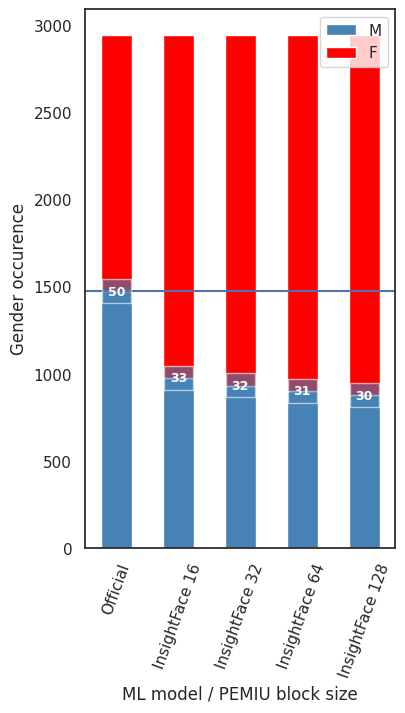

In [19]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
fig, ax = plt.subplots(1, 1, figsize = (4, 7))

#create stacked bar chart
df_insightface_gender_pred_distribution.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
# ax.set_title(f"Distribution of predicted gender using InsightFace\n" \
#              f"on PEMIU enhanced embeddings with {face_extractor} at varying block sizes")
#ax.set_title(f"{face_extractor}")
ax.axhline(df_insightface_gender_pred_distribution.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 5:
        percent_male = df_insightface_gender_pred_distribution['M'][index]
        percent_total = df_insightface_gender_pred_distribution.iloc[index][1] + df_insightface_gender_pred_distribution.iloc[index][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.savefig(f'{plt_savepath}04_09_gender_predict_insightface_gender_distribution.svg', bbox_inches='tight')
plt.show()

### InsightFace gender prediction on images synthesized from unprotected templates, which pass the system threshold TH100 and TH1000

In [65]:
labels = ['InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
df_gender_pred_insightface_blocksizes = pd.DataFrame(columns=['blocksize', 'Successful predictions', 'Possible predictions'])

# Filter dataframe to only contain rows that were predicted at blocksize
for index, blocksize in enumerate(block_sizes):
    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    total_number_of_predictions = len(df)
    correct_predictions = len(df[df['gender_official'] == df[f'gender_insightface_{blocksize}']])
    df_gender_pred_insightface_blocksizes.loc[index] = [blocksize, correct_predictions, total_number_of_predictions]
df_gender_pred_insightface_blocksizes

blocksize  Successful predictions  Possible predictions
0        16                     201                   405
1        32                     282                   561
2        64                     719                  1408
3       128                    1514                  2827

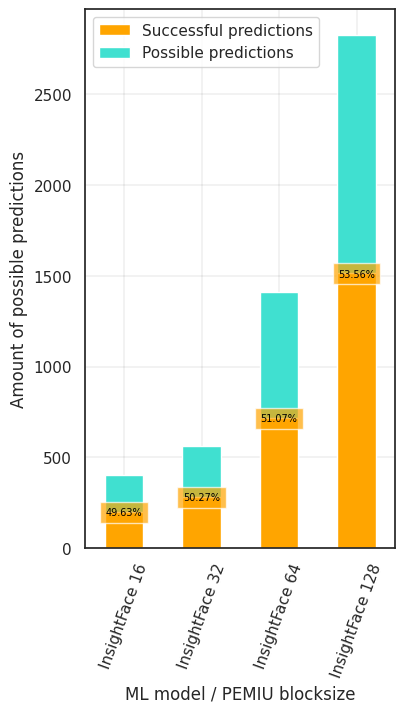

In [66]:
# set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize = (4, 7))
df_gender_pred_insightface_blocksizes.iloc[:,[0,1]].set_index('blocksize').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_gender_pred_insightface_blocksizes.iloc[:,[0,2]].set_index('blocksize').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack with InsightFace on synthesized images using {face_extractor}.\n" \
#              "Considering only identities, where the reconstrcuted image passes the FMR100 threshold")

ax.grid(visible=True, which='major', color='black', linewidth=0.075)
#ax.set_title(f"{face_extractor}")
for index, p in enumerate(ax.patches):
    if index < 4:
        percentage = round(df_gender_pred_insightface_blocksizes['Successful predictions'][index] / df_gender_pred_insightface_blocksizes['Possible predictions'][index] * 100, 2)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}%', (x-0.25, y-20), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        
plt.savefig(f'{plt_savepath}04_10_gender_predict_insightface_success_rate_th100.svg', bbox_inches='tight')
plt.show()

In [67]:
labels = ['InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
df_gender_pred_insightface_blocksizes = pd.DataFrame(columns=['blocksize', 'Successful predictions', 'Possible predictions'])

# Filter dataframe to only contain rows that were predicted at blocksize
for index, blocksize in enumerate(block_sizes):
    df = df_insightface_prediction_th1000[df_insightface_prediction_th1000[f'gender_insightface_{blocksize}'].notnull().values]
    total_number_of_predictions = len(df)
    correct_predictions = len(df[df['gender_official'] == df[f'gender_insightface_{blocksize}']])
    df_gender_pred_insightface_blocksizes.loc[index] = [blocksize, correct_predictions, total_number_of_predictions]
df_gender_pred_insightface_blocksizes

blocksize  Successful predictions  Possible predictions
0        16                      15                    21
1        32                      46                    82
2        64                     271                   475
3       128                    1029                  1723

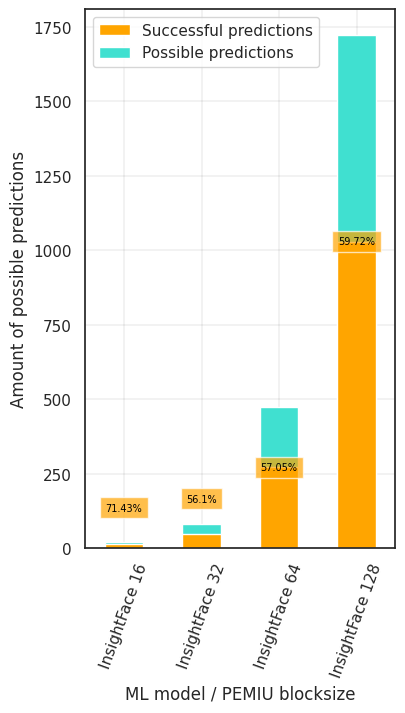

In [68]:
# set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize = (4, 7))
df_gender_pred_insightface_blocksizes.iloc[:,[0,1]].set_index('blocksize').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_gender_pred_insightface_blocksizes.iloc[:,[0,2]].set_index('blocksize').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack with InsightFace on synthesized images with {face_extractor}\n" \
#              "Considering only identities, where the reconstrcuted image passes the FMR1000 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 4:
        percentage = round(df_gender_pred_insightface_blocksizes['Successful predictions'][index] / df_gender_pred_insightface_blocksizes['Possible predictions'][index] * 100, 2)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        # Form an offset to place the label above columns when columns are very small
        offset = 0
        if y < 115:
            offset = +110
        else:
            offset = -10
        ax.annotate(f'{percentage}%', (x-0.25, y+offset), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        
plt.savefig(f'{plt_savepath}04_11_gender_predict_insightface_success_rate_th1000.svg', bbox_inches='tight')
plt.show()

---

# End of evaluation

In [91]:
##################################################################
# Redundant code
##################################################################

### Sankey flow diagrams of gender prediction at TH100

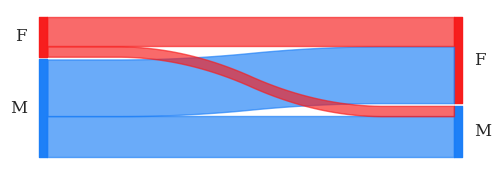

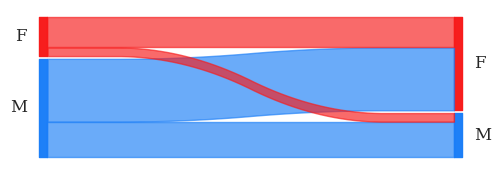

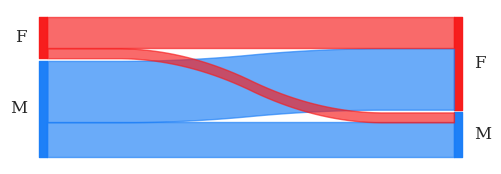

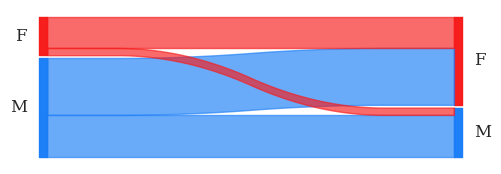

In [62]:
for index, blocksize in enumerate(block_sizes):
    fig, ax = plt.subplots(1, 1, figsize = (6, 2))

    colorDict = {
        'M':'#1b7ef7',
        'F':'#f71b1b',
    }

    gender_flow = pd.DataFrame()

    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official', f'gender_insightface_{blocksize}']]

    fig = sankey(
        gender_flow['gender_official'], gender_flow[f'gender_insightface_{blocksize}'], aspect=10, colorDict=colorDict,
        leftLabels=['M','F'],
        rightLabels=['M','F'],
        fontsize=12
    )

    plt.show()

In [64]:
df_insightface_gender_pred_distribution = pd.DataFrame()

for index, blocksize in enumerate(block_sizes):
    gender_flow = pd.DataFrame()
    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official', f'gender_insightface_{blocksize}']]
    df_insightface_gender_pred_distribution[f'InsightFace {blocksize}'] = gender_flow[f'gender_insightface_{blocksize}'].value_counts()
    
df_insightface_gender_pred_distribution['gender_official'] = df['gender_official'].value_counts()

# Reorder dataframe
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.T
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.iloc[[4, 0, 1, 2, 3],[1,0]]
df_insightface_gender_pred_distribution.index.name = 'Model'
df_insightface_gender_pred_distribution.reset_index(inplace=True)
df_insightface_gender_pred_distribution

Model     M     F
0  gender_official  1916   739
1   InsightFace 16   282   475
2   InsightFace 32   235   499
3   InsightFace 64   500  1040
4  InsightFace 128   956  1699

In [65]:
df_insightface_gender_pred_distribution.iloc[1][1] + df_insightface_gender_pred_distribution.iloc[1][2]

757

### Distribution of predicted gender with InsightFace at TH100

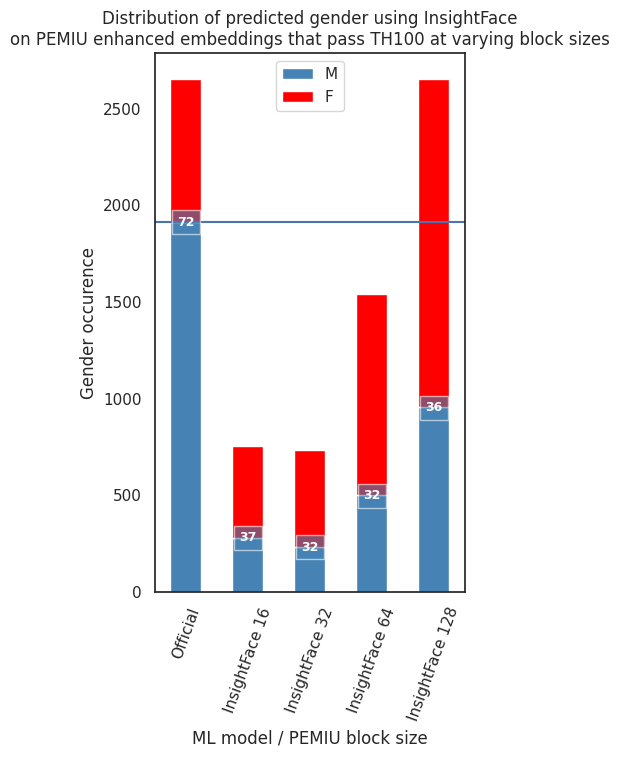

In [66]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
fig, ax = plt.subplots(1, 1, figsize = (4, 7))

#create stacked bar chart
df_insightface_gender_pred_distribution.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
ax.set_title("Distribution of predicted gender using InsightFace\n" \
             "on PEMIU enhanced embeddings that pass TH100 at varying block sizes")

ax.axhline(df_insightface_gender_pred_distribution.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 5:
        percent_male = df_insightface_gender_pred_distribution['M'][index]
        percent_total = df_insightface_gender_pred_distribution.iloc[index][1] + df_insightface_gender_pred_distribution.iloc[index][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.show()